In [47]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.inspection import DecisionBoundaryDisplay

from scipy import stats
from pca import pca
from IPython.display import display
import dataframe_image as dfi

import warnings
    
# warnings -> to silence warnings

warnings.filterwarnings("ignore")
np.set_printoptions(precision=5, suppress=True)


RANDOM_STATE = 42
N_JOBS = -1
class_names = ["Canis", "Dysg. Equisimilis", "Dysg. Dysgalactiae"]

map_target = {
    "Streptococcus canis": 0,
    "Streptococcus dysgalactiae subsp. equisimilis": 1,
    "Streptococcus dysgalactiae subsp. dysgalactiae": 2
}

map_target_inv = {
    0: "Strept. canis",
    1: "Strept. dysg. equisimilis",
    2: "Strept. dysg. dysgalactiae"
}

map_target_antibiotici = {
    "S" : 1,
    "NS" : 0
}
start = 9
n_antibiotici = 9
n_geni = 27
n_virulenza = 18
n = 46

In [48]:
df = pd.read_csv("../data/Dati_Matemaldomics_"+str(n)+"picchi.csv",
                        delimiter=';', index_col='ID Strain')
animal  = df[['Animal species of origin']]
lancefield = df[['LANCEFIELD GROUP']]
haemolysis = df[['Haemolysis']]
subspecies = df[['Putative Subspecies']]
st = df[[df.columns[4]]]
maldi = df[df.columns[start:start+n]]
antibiotici = df[df.columns[start+n:start+n+n_antibiotici]]
geni_antibiotici = df[df.columns[start+n+n_antibiotici:start+n+n_antibiotici+n_geni]]
virulenza = df[df.columns[start+n+n_antibiotici+n_geni:start+n+n_antibiotici+n_geni+n_virulenza]]

maldi.fillna(0, inplace=True)
maldi = maldi.replace(',', '.', regex=True)
columns = maldi.columns
for column in columns:
    maldi[column] = maldi[column].astype(float)
#display(maldi)

targets = {'antibiotici' : antibiotici,
            'geni_antibiotici' : geni_antibiotici,
            'virulenza' : virulenza}

feats_agg = {'lancefield' : lancefield,
            'haemolysis' : haemolysis,
            'subspecies' : subspecies,
            'animal' : animal}

for str_target,target in targets.items():
    columns = target.columns
    for column in columns:
        if str_target == 'antibiotici':
            target[column] = df[column].map(map_target_antibiotici)
        rapporto = (target[column] == 0).sum() / target.shape[0]
        #print(column+" : "+str(rapporto))
        if rapporto < 0.15 or rapporto > 0.85:
            target.drop([column], axis=1, inplace=True)
    
    #display(target)

#print(list_column)
targets['st'] = st

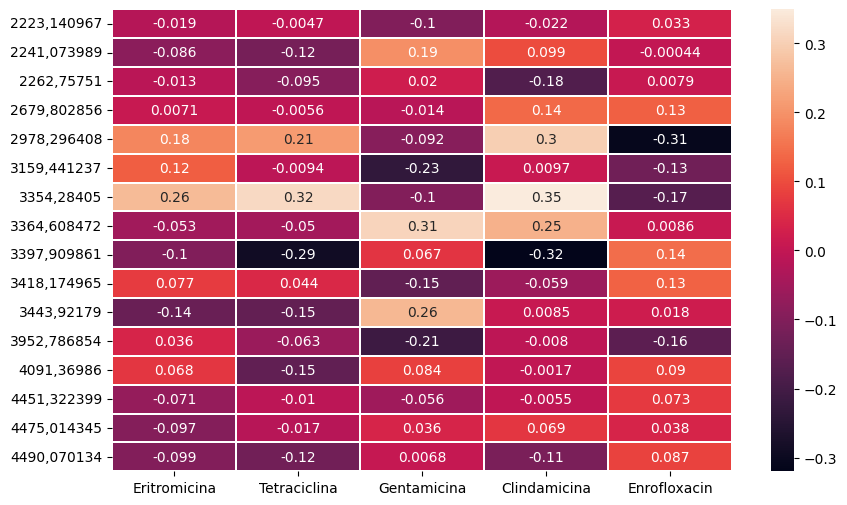

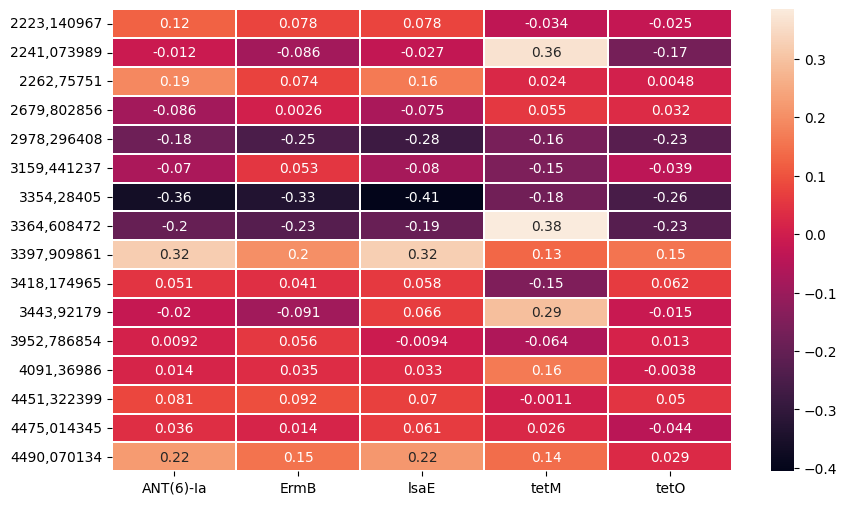

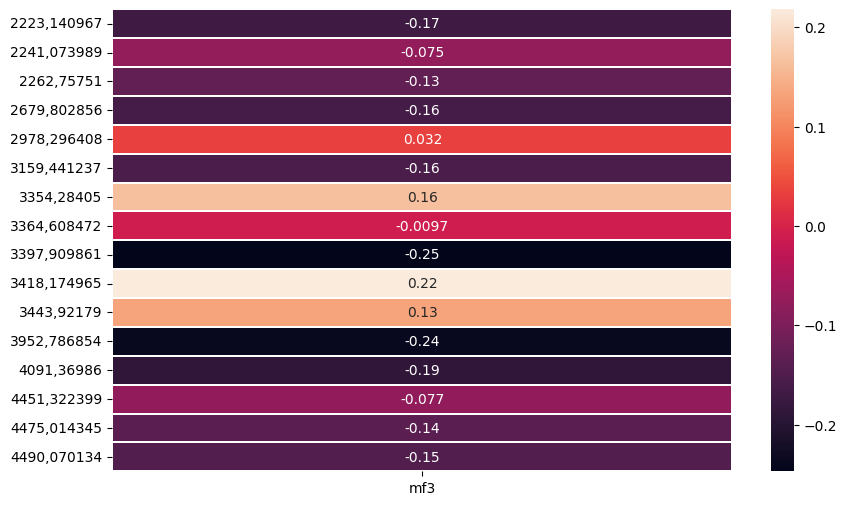

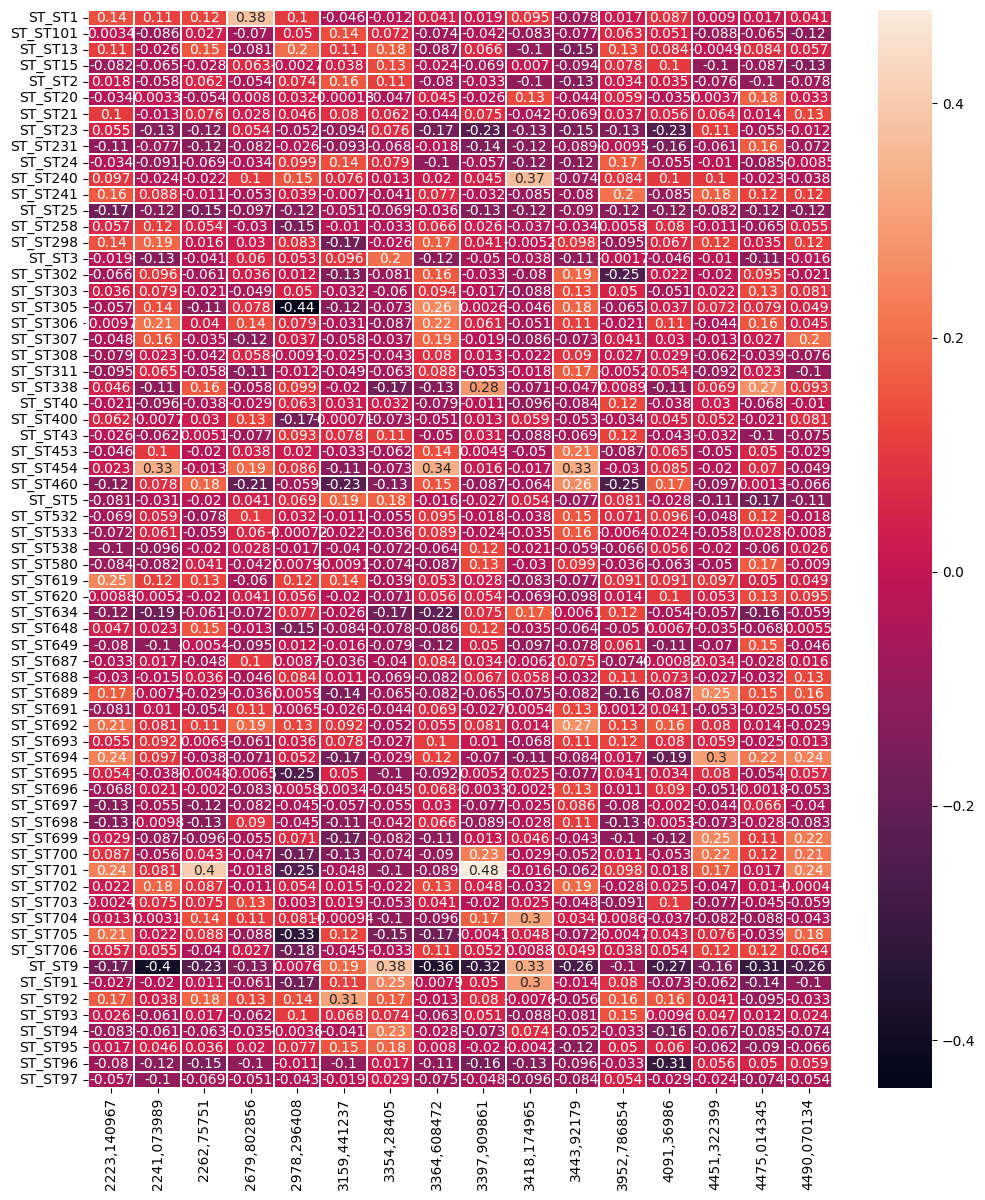

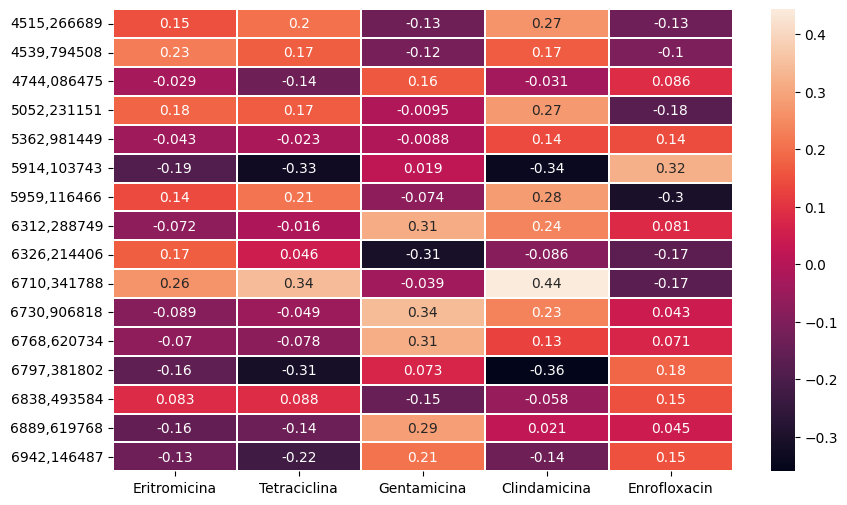

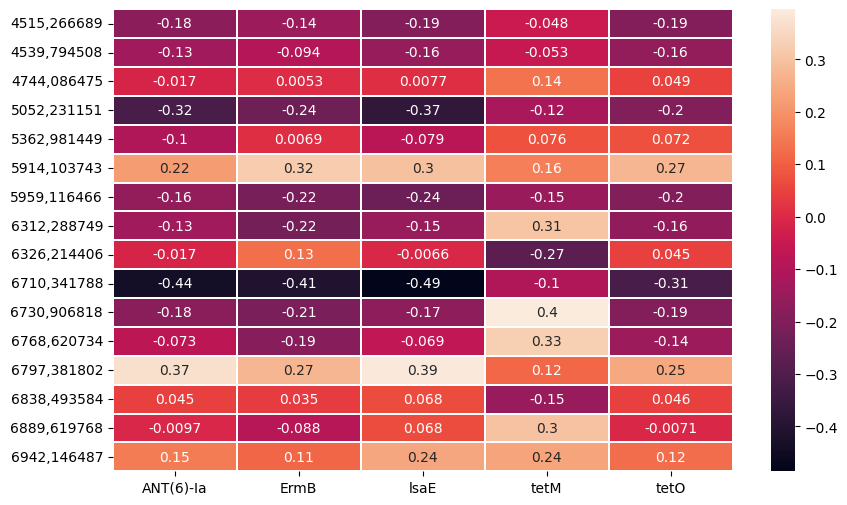

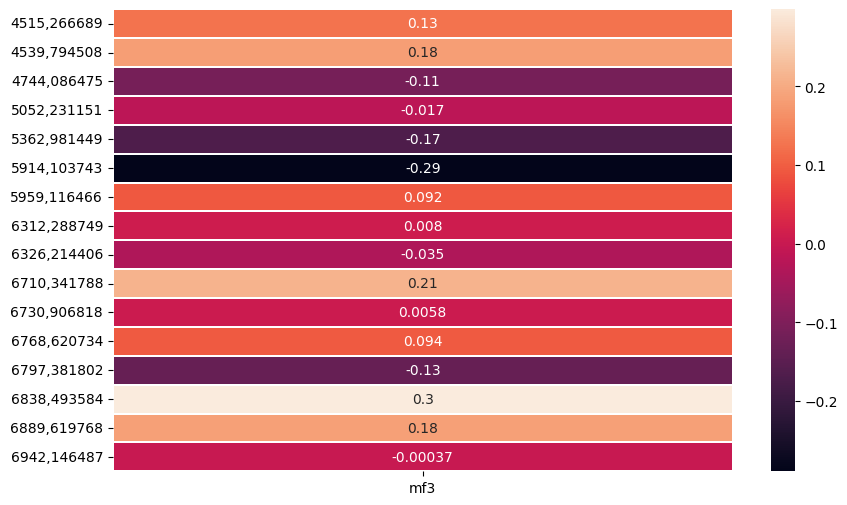

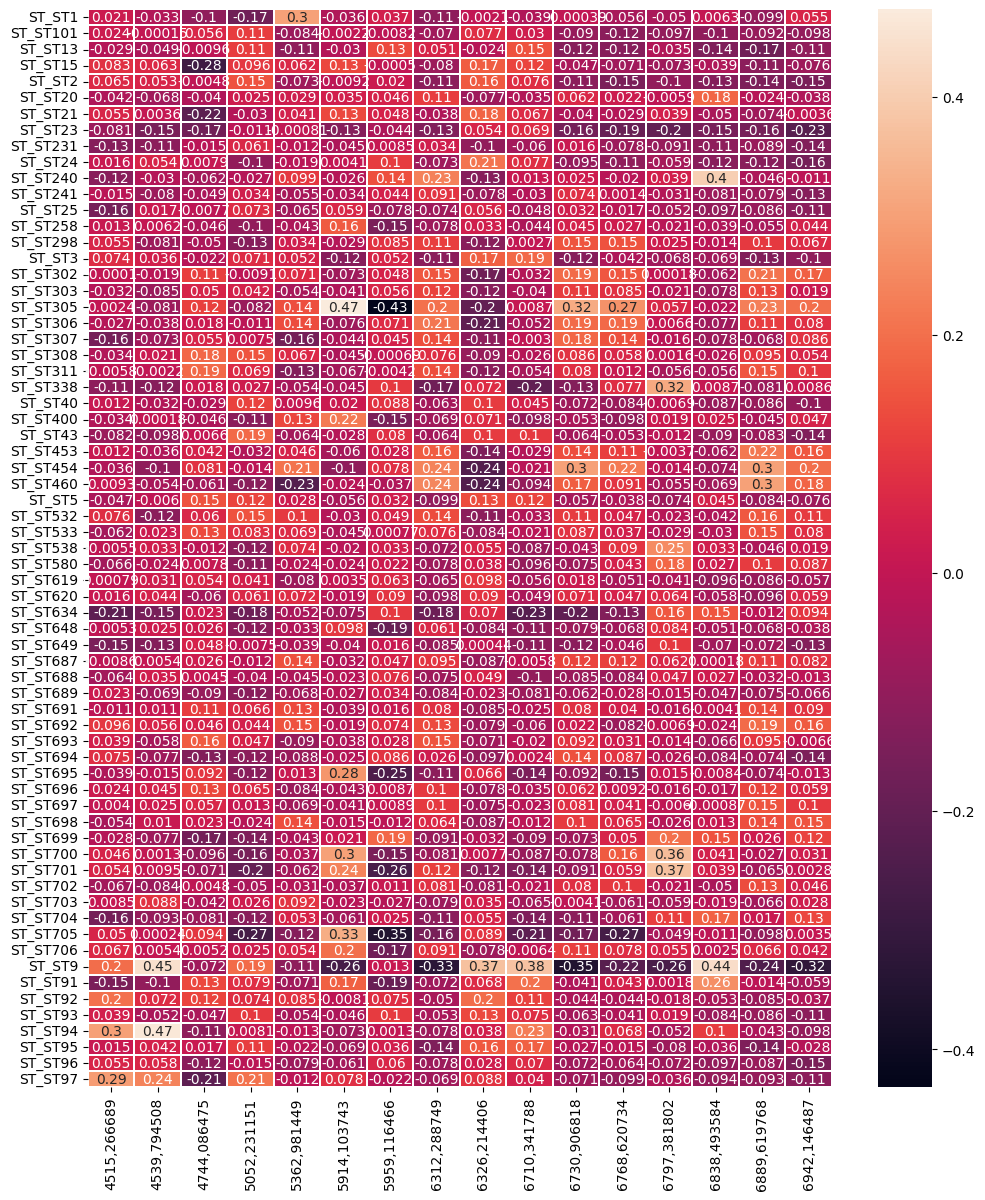

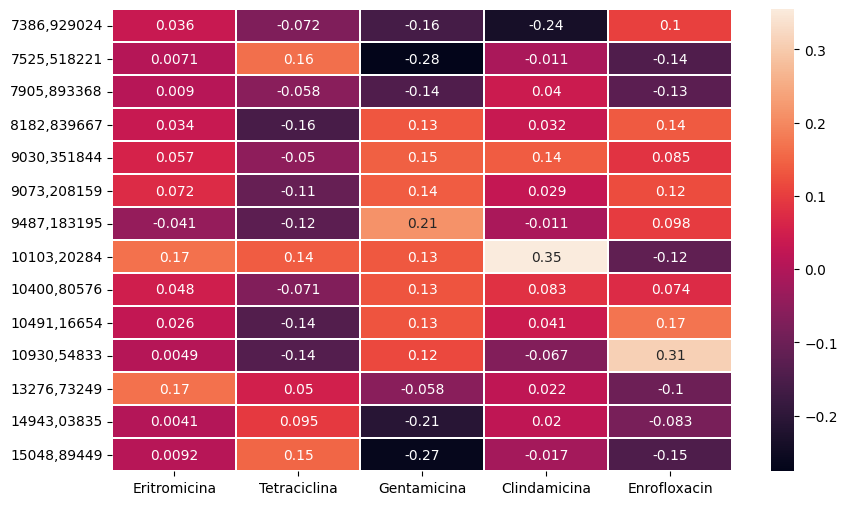

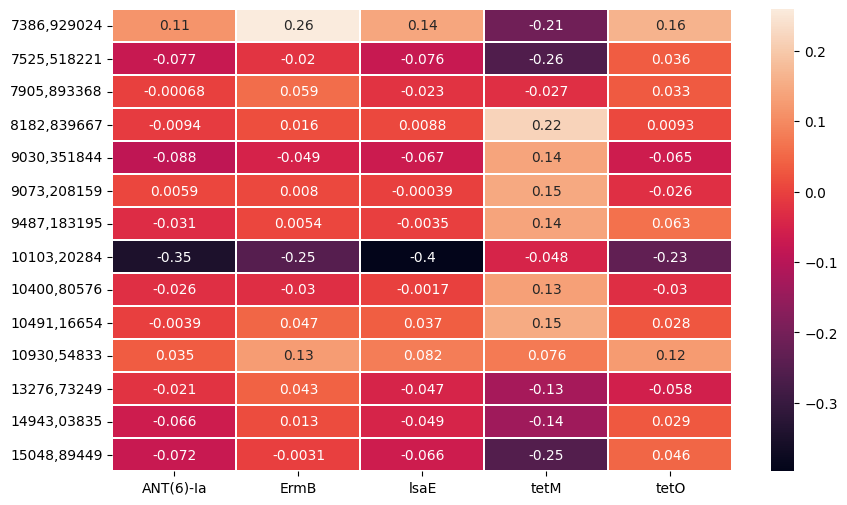

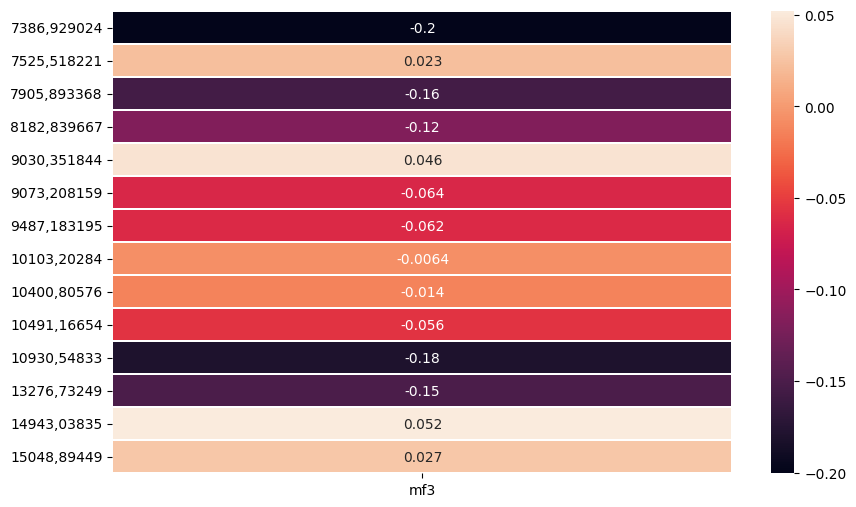

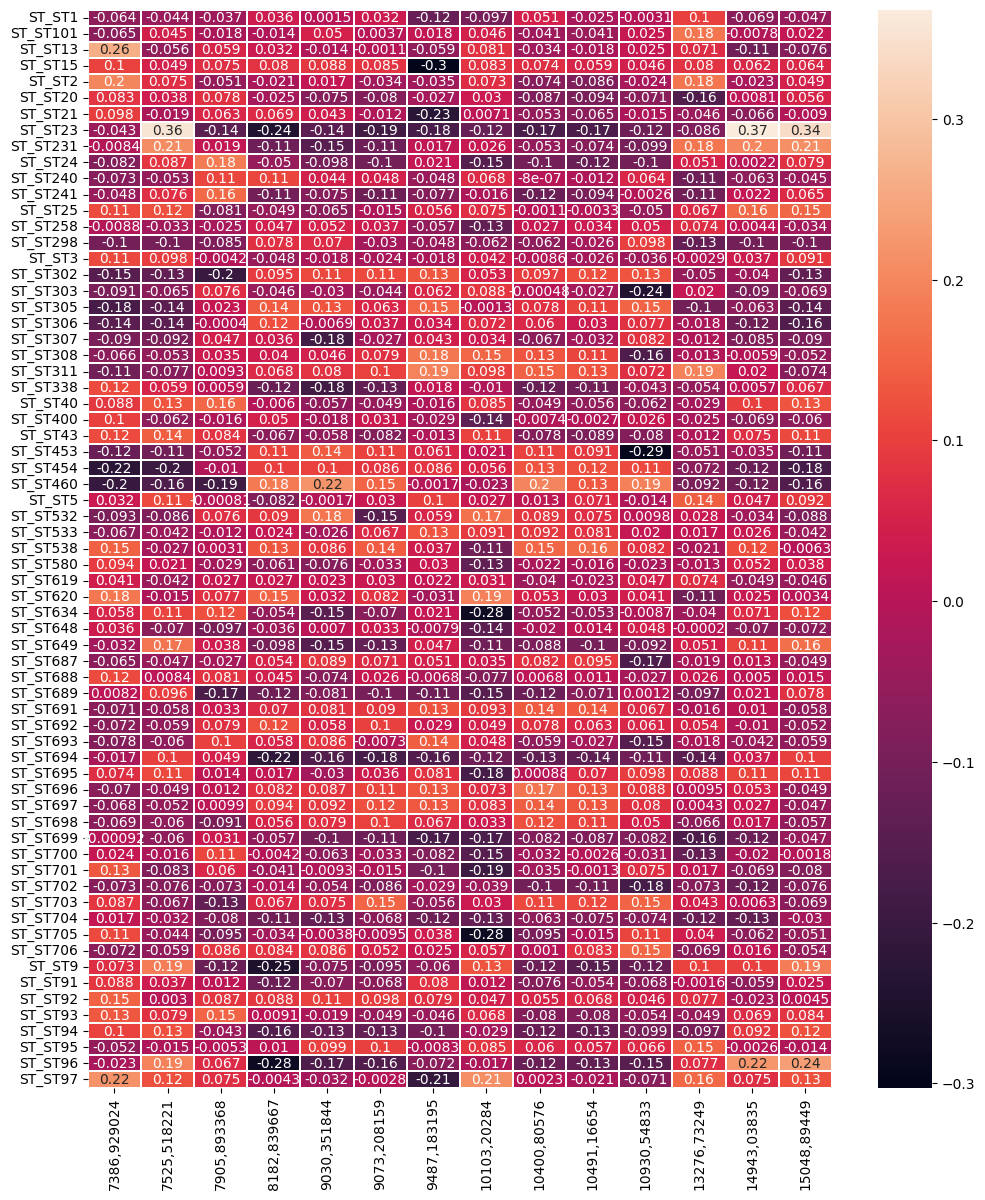

In [49]:
num_picchi = 16
#display(maldi)
#print(int(n/num_picchi)*num_picchi)
columns_i = [*range(0,int(n/num_picchi)*num_picchi+1,num_picchi)] 
columns_f = [*range(num_picchi,n,num_picchi),n]
dict_column = {columns_i[i]: columns_f[i] for i in range(len(columns_i))}

for column_i,column_f in dict_column.items():
    maldi_reduced = maldi.iloc[:, column_i:column_f]
    #display(maldi_reduced)
    for str_target, target in targets.items():
        if str_target == 'st':
            target = pd.DataFrame.from_dict(pd.get_dummies(target))
            #print(targ_feat.corr()[feat_agg.columns])
            plt.figure(figsize=(12, 14))
        else:
            plt.figure(figsize=(10, 6))
        targ_feat = pd.concat([target, maldi_reduced], axis=1)
        #print()
        if target.shape[1] > maldi_reduced.shape[1]:
            corr_target = targ_feat.corr().filter(items = maldi_reduced.columns, axis=1).filter(items = target.columns, axis=0)
            sns.heatmap(corr_target, annot=True, linewidths=0.2)
        else:
            corr_target = targ_feat.corr().filter(items = maldi_reduced.columns, axis=0).filter(items = target.columns, axis=1)
            sns.heatmap(corr_target, annot=True, linewidths=0.2)
        
        
        #plt.savefig('Risultati/Correlation/Maldi/'+str_target+'_'+str(n)+'_'+str(column_i)+'_'+str(column_f)+'.png')

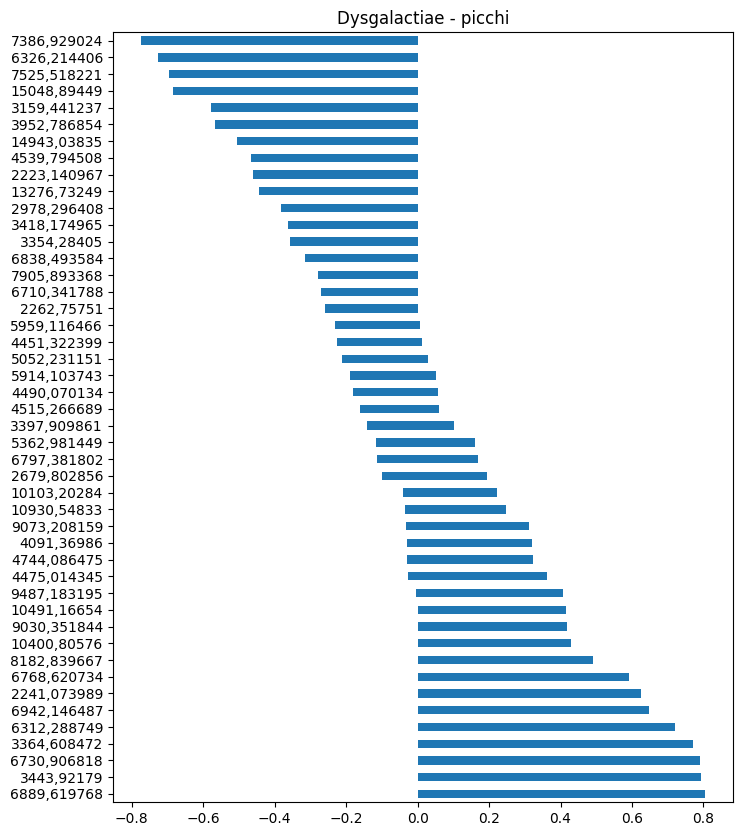

In [50]:
targets_cp = {'antibiotici' : antibiotici,
            'geni_antibiotici' : geni_antibiotici,
            'virulenza' : virulenza,
            'subspecies' : subspecies}
for str_target, target in targets_cp.items():
    columns = target.columns
    for column in columns:
        if str_target == 'subspecies':
            target = pd.DataFrame.from_dict(pd.get_dummies(target))
            target = target.rename(columns = {'Putative Subspecies_Streptococcus canis': "Canis",
                'Putative Subspecies_Streptococcus dysgalactiae subsp. equisimilis' : "Equisimilis",
                'Putative Subspecies_Streptococcus dysgalactiae subsp. dysgalactiae' : "Dysgalactiae"})
            #print(target)
            for col_subs in ['Canis', 'Equisimilis', 'Dysgalactiae']:
                targ_feat = pd.concat([target[col_subs], maldi], axis=1)
                #display(targ_feat)
                targ_feat.corr(method="spearman")[col_subs][1:].sort_values(ascending=False).plot(figsize=(8, 10), kind="barh", title=col_subs+' - picchi')    
                #plt.savefig('../Risultati/Correlation/Best/'+str_target+'/'+col_subs+'_picchiMaldi'+str(n)+'.png')
        else:
            targ_feat = pd.concat([target[column], maldi], axis=1)
            #display(targ_feat)
            targ_feat.corr(method="spearman")[column][1:].sort_values(ascending=False).plot(figsize=(8, 10), kind="barh", title=column+' - picchi')    
            #plt.savefig('../Risultati/Correlation/Best/'+str_target+'/'+column+'_picchiMaldi'+str(n)+'.png')

2223,140967  2241,073989  2262,75751  2679,802856  2978,296408  \
ID Strain                                                                   
V13           0.000665     0.000180    0.000198     0.000059     0.000865   
V142          0.000648     0.000156    0.000192     0.000400     0.000698   
V151          0.000545     0.000331    0.000204     0.000277     0.000613   
V160          0.000509     0.000191    0.000193     0.000266     0.000489   
V161          0.000517     0.000118    0.000158     0.000163     0.000610   
...                ...          ...         ...          ...          ...   
V800          0.000456     0.000253    0.000125     0.000061     0.000586   
V82           0.000459     0.000121    0.000147     0.000270     0.000571   
V90           0.000505     0.000154    0.000158     0.000181     0.000610   
V91           0.000520     0.000124    0.000169     0.000174     0.000597   
V95           0.000538     0.000144    0.000175     0.000062     0.000137   

           3159,441237  3354,28405  3364,608472  3397,909861  3418,174965  \
ID Strain                                                                   
V13           0.000497    0.000197     0.000272     0.000578     0.000198   
V142          0.000414    0.000684     0.000349     0.000617     0.000494   
V151          0.000464    0.000279     0.001031     0.000624     0.000409   
V160          0.000358    0.000628     0.000692     0.000564     0.000611   
V161          0.000502    0.000621     0.000315     0.000507     0.000638   
...                ...         ...          ...          ...          ...   
V800          0.000365    0.000258     0.001095     0.000537     0.000214   
V82           0.000338    0.000596     0.000321     0.000537     0.000668   
V90           0.000473    0.000374     0.000525     0.000513     0.000377   
V91           0.000414    0.000572     0.000310     0.000532     0.000646   
V95           0.000414    0.000090     0.000196     0.000574     0.000429   

           3443,92179  3952,786854  4091,36986  4451,322399  4475,014345  \
ID Strain                                                                  
V13          0.000094     0.000806    0.000504     0.001233     0.000284   
V142         0.000161     0.000641    0.000499     0.001305     0.000386   
V151         0.000176     0.000641    0.000559     0.001035     0.000320   
V160         0.000185     0.000648    0.000659     0.000995     0.000342   
V161         0.000180     0.000679    0.000492     0.001046     0.000260   
...               ...          ...         ...          ...          ...   
V800         0.000138     0.000633    0.000572     0.001221     0.000361   
V82          0.000206     0.000606    0.000529     0.001083     0.000314   
V90          0.000130     0.000605    0.000526     0.001042     0.000333   
V91          0.000212     0.000670    0.000528     0.001028     0.000351   
V95          0.000163     0.000586    0.000500     0.001114     0.000305   

           4490,070134  
ID Strain               
V13           0.000386  
V142          0.000366  
V151          0.000297  
V160          0.000264  
V161          0.000260  
...                ...  
V800          0.000496  
V82           0.000298  
V90           0.000284  
V91           0.000272  
V95           0.000392  

[154 rows x 16 columns]

Canis  Dysgalactiae  Equisimilis
ID Strain                                  
V13            1             0            0
V142           1             0            0
V151           1             0            0
V160           1             0            0
V161           1             0            0
...          ...           ...          ...
V800           0             1            0
V82            1             0            0
V90            1             0            0
V91            1             0            0
V95            0             0            1

[154 rows x 3 columns]

4515,266689  4539,794508  4744,086475  5052,231151  5362,981449  \
ID Strain                                                                    
V13           0.000384     0.000195     0.000631     0.000310     0.000047   
V142          0.000491     0.000342     0.000420     0.000263     0.000623   
V151          0.000403     0.000376     0.000582     0.000326     0.000401   
V160          0.000441     0.000400     0.000063     0.000333     0.000403   
V161          0.000394     0.000343     0.000718     0.000362     0.000254   
...                ...          ...          ...          ...          ...   
V800          0.000240     0.000229     0.000787     0.000315     0.000038   
V82           0.000395     0.000349     0.000368     0.000308     0.000488   
V90           0.000411     0.000400     0.000646     0.000339     0.000272   
V91           0.000433     0.000361     0.000477     0.000336     0.000254   
V95           0.000400     0.000306     0.000735     0.000121     0.000081   

           5914,103743  5959,116466  6312,288749  6326,214406  6710,341788  \
ID Strain                                                                    
V13           0.000236     0.001131     0.000094     0.000554     0.000264   
V142          0.000101     0.001018     0.000126     0.000590     0.000986   
V151          0.000185     0.000829     0.000096     0.000539     0.000504   
V160          0.000566     0.000705     0.000129     0.000576     0.000870   
V161          0.000080     0.000850     0.000099     0.000564     0.000855   
...                ...          ...          ...          ...          ...   
V800          0.000235     0.000988     0.000700     0.000137     0.000611   
V82           0.000349     0.000926     0.000114     0.000549     0.000938   
V90           0.000243     0.000891     0.000128     0.000598     0.000555   
V91           0.000085     0.000851     0.000115     0.000560     0.000826   
V95           0.000781     0.000207     0.000068     0.000399     0.000073   

           6730,906818  6768,620734  6797,381802  6838,493584  6889,619768  \
ID Strain                                                                    
V13           0.000170     0.000166     0.000663     0.000210     0.000103   
V142          0.000414     0.000391     0.000771     0.000546     0.000186   
V151          0.001330     0.000568     0.000746     0.000449     0.000201   
V160          0.000780     0.000354     0.000707     0.000657     0.000196   
V161          0.000324     0.000305     0.000622     0.000858     0.000231   
...                ...          ...          ...          ...          ...   
V800          0.001666     0.000580     0.000790     0.000324     0.000249   
V82           0.000414     0.000409     0.000772     0.001036     0.000328   
V90           0.000602     0.000283     0.000658     0.000419     0.000145   
V91           0.000363     0.000362     0.000684     0.000916     0.000286   
V95           0.000277     0.000221     0.000776     0.000503     0.000242   

           6942,146487  
ID Strain               
V13           0.000145  
V142          0.000288  
V151          0.000308  
V160          0.000316  
V161          0.000231  
...                ...  
V800          0.000329  
V82           0.000372  
V90           0.000273  
V91           0.000313  
V95           0.000242  

[154 rows x 16 columns]

Canis  Dysgalactiae  Equisimilis
ID Strain                                  
V13            1             0            0
V142           1             0            0
V151           1             0            0
V160           1             0            0
V161           1             0            0
...          ...           ...          ...
V800           0             1            0
V82            1             0            0
V90            1             0            0
V91            1             0            0
V95            0             0            1

[154 rows x 3 columns]

7386,929024  7525,518221  7905,893368  8182,839667  9030,351844  \
ID Strain                                                                    
V13           0.000164     0.000301     0.000819     0.000457     0.000206   
V142          0.000291     0.000309     0.000712     0.000505     0.000219   
V151          0.000157     0.000115     0.000677     0.000512     0.000261   
V160          0.000316     0.000212     0.000711     0.000635     0.000311   
V161          0.000042     0.000349     0.000713     0.000477     0.000206   
...                ...          ...          ...          ...          ...   
V800          0.000025     0.000090     0.000776     0.000617     0.000102   
V82           0.000319     0.000198     0.000758     0.000592     0.000263   
V90           0.000377     0.000238     0.000675     0.000525     0.000288   
V91           0.000065     0.000332     0.000744     0.000534     0.000237   
V95           0.000363     0.000085     0.000655     0.000482     0.000215   

           9073,208159  9487,183195  10103,20284  10400,80576  10491,16654  \
ID Strain                                                                    
V13           0.000133     0.000587     0.000180     0.000065     0.000065   
V142          0.000205     0.000465     0.000193     0.000142     0.000116   
V151          0.000263     0.000585     0.000235     0.000198     0.000152   
V160          0.000312     0.000083     0.000241     0.000242     0.000187   
V161          0.000224     0.000711     0.000242     0.000156     0.000116   
...                ...          ...          ...          ...          ...   
V800          0.000195     0.000843     0.000250     0.000088     0.000109   
V82           0.000277     0.000452     0.000254     0.000211     0.000162   
V90           0.000310     0.000671     0.000237     0.000224     0.000185   
V91           0.000259     0.000514     0.000237     0.000202     0.000150   
V95           0.000182     0.000720     0.000066     0.000081     0.000101   

           10930,54833  13276,73249  14943,03835  15048,89449  
ID Strain                                                      
V13           0.000172     0.000076     0.000058     0.000142  
V142          0.000165     0.000067     0.000067     0.000194  
V151          0.000208     0.000084     0.000092     0.000069  
V160          0.000245     0.000082     0.000075     0.000136  
V161          0.000154     0.000093     0.000072     0.000203  
...                ...          ...          ...          ...  
V800          0.000298     0.000060     0.000073     0.000059  
V82           0.000203     0.000059     0.000070     0.000144  
V90           0.000230     0.000089     0.000080     0.000137  
V91           0.000175     0.000092     0.000078     0.000214  
V95           0.000213     0.000067     0.000063     0.000043  

[154 rows x 14 columns]

Canis  Dysgalactiae  Equisimilis
ID Strain                                  
V13            1             0            0
V142           1             0            0
V151           1             0            0
V160           1             0            0
V161           1             0            0
...          ...           ...          ...
V800           0             1            0
V82            1             0            0
V90            1             0            0
V91            1             0            0
V95            0             0            1

[154 rows x 3 columns]

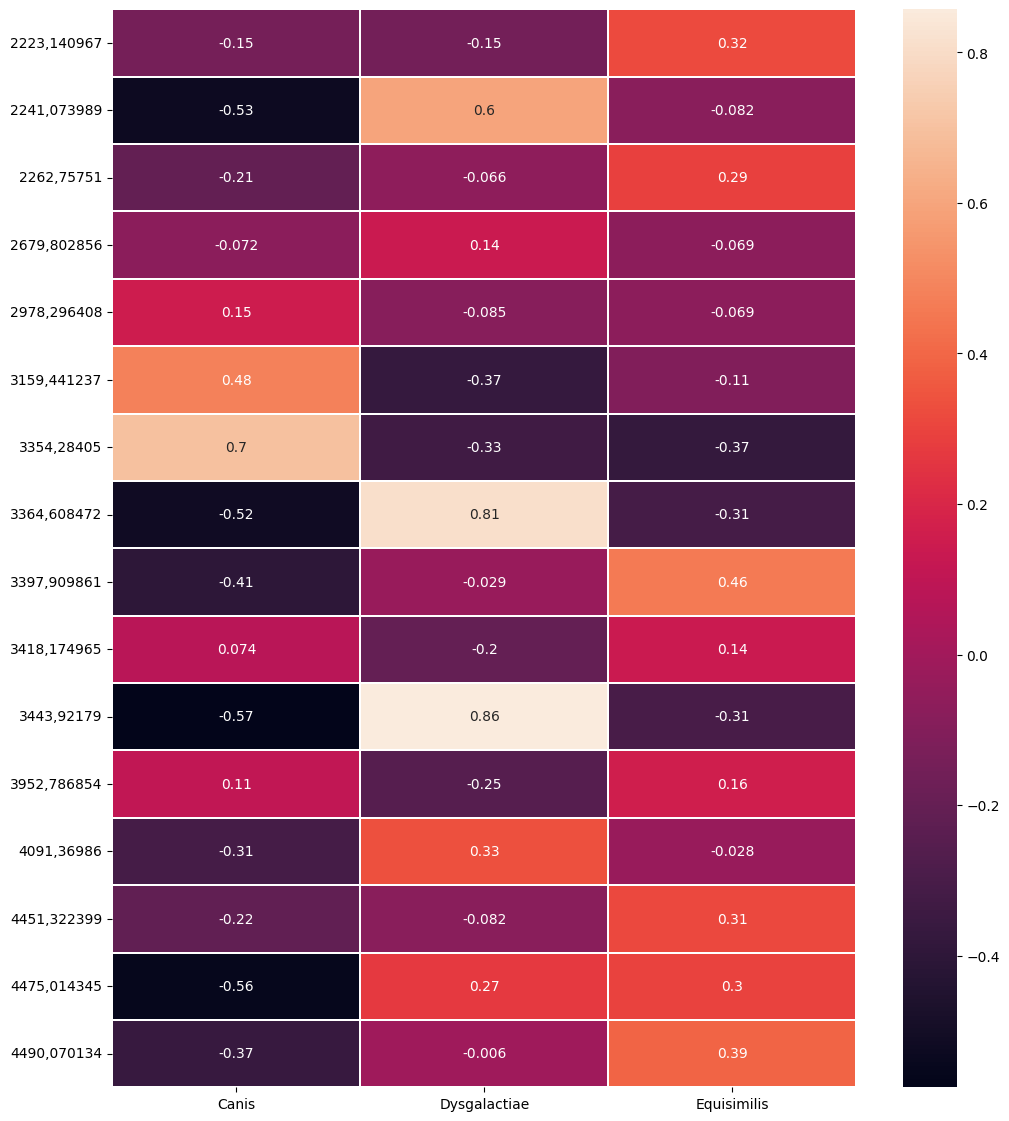

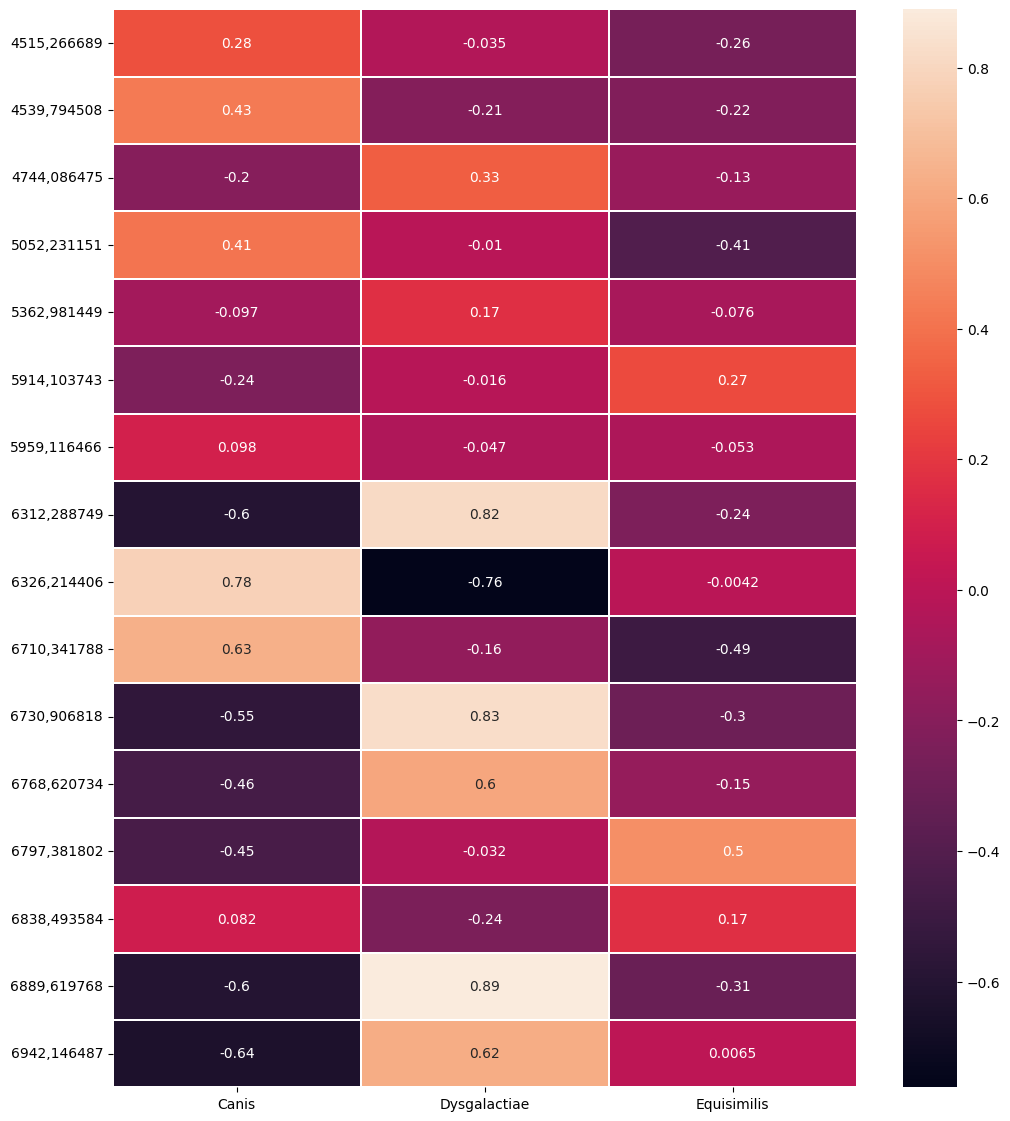

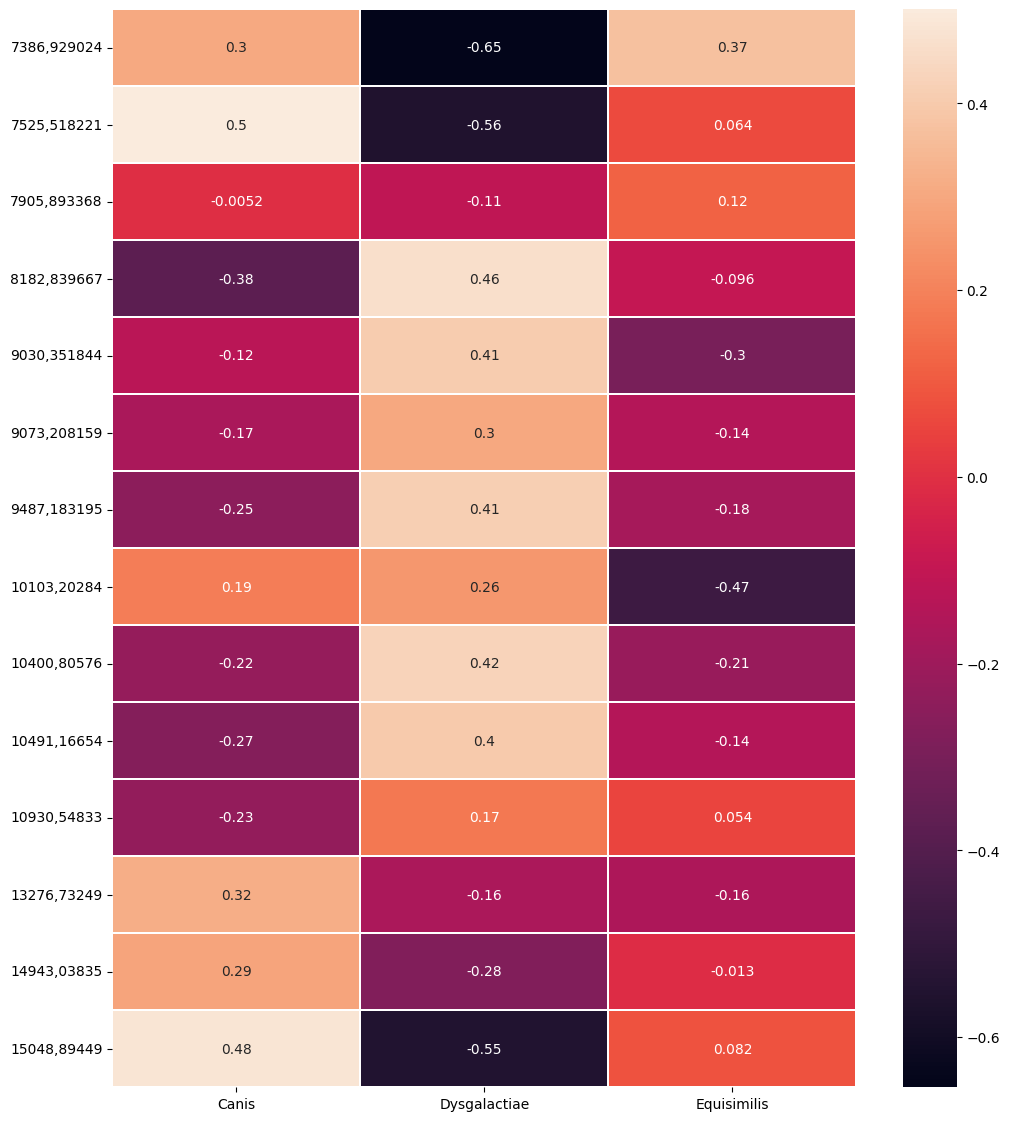

In [51]:
targets_cp = {'subspecies' : subspecies}

for column_i,column_f in dict_column.items():
    maldi_reduced = maldi.iloc[:, column_i:column_f]
    display(maldi_reduced)
    
    for str_target, target in targets_cp.items():
        if str_target == 'subspecies':
            target = pd.DataFrame.from_dict(pd.get_dummies(target))
            target = target.rename(columns = {'Putative Subspecies_Streptococcus canis': "Canis",
                'Putative Subspecies_Streptococcus dysgalactiae subsp. equisimilis' : "Equisimilis",
                'Putative Subspecies_Streptococcus dysgalactiae subsp. dysgalactiae' : "Dysgalactiae"})
            display(target)
            #print(targ_feat.corr()[feat_agg.columns])
            plt.figure(figsize=(12, 14))
        else:
            plt.figure(figsize=(10, 6))
        targ_feat = pd.concat([target, maldi_reduced], axis=1)
        #print()
        if target.shape[1] > maldi_reduced.shape[1]:
            corr_target = targ_feat.corr().filter(items = maldi_reduced.columns, axis=1).filter(items = target.columns, axis=0)
            sns.heatmap(corr_target, annot=True, linewidths=0.2)
        else:
            corr_target = targ_feat.corr().filter(items = maldi_reduced.columns, axis=0).filter(items = target.columns, axis=1)
            sns.heatmap(corr_target, annot=True, linewidths=0.2)
        
        
        #plt.savefig('../Risultati/Correlation/Maldi/'+str_target+'_'+str(n)+'_'+str(column_i)+'_'+str(column_f)+'.png')

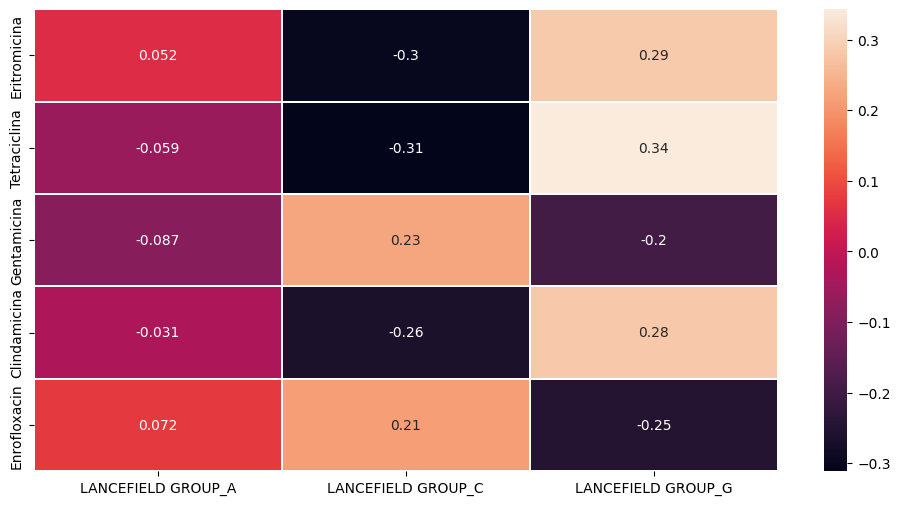

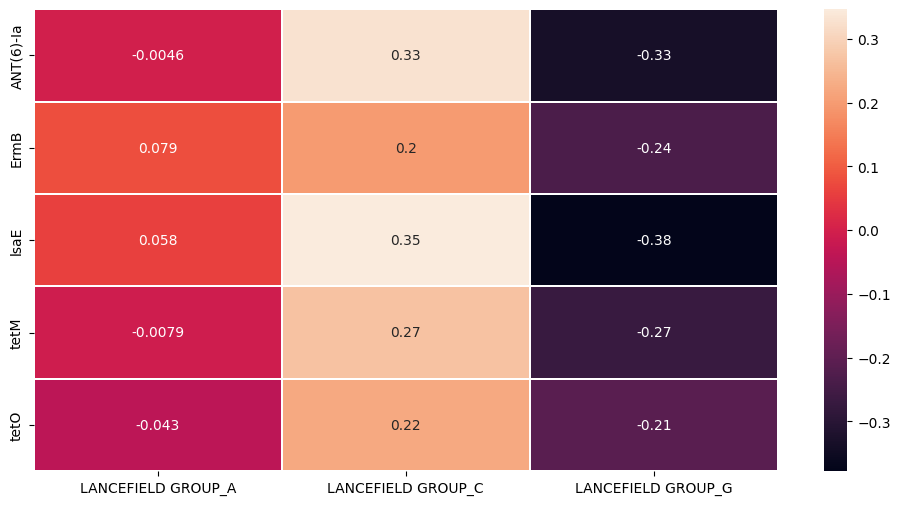

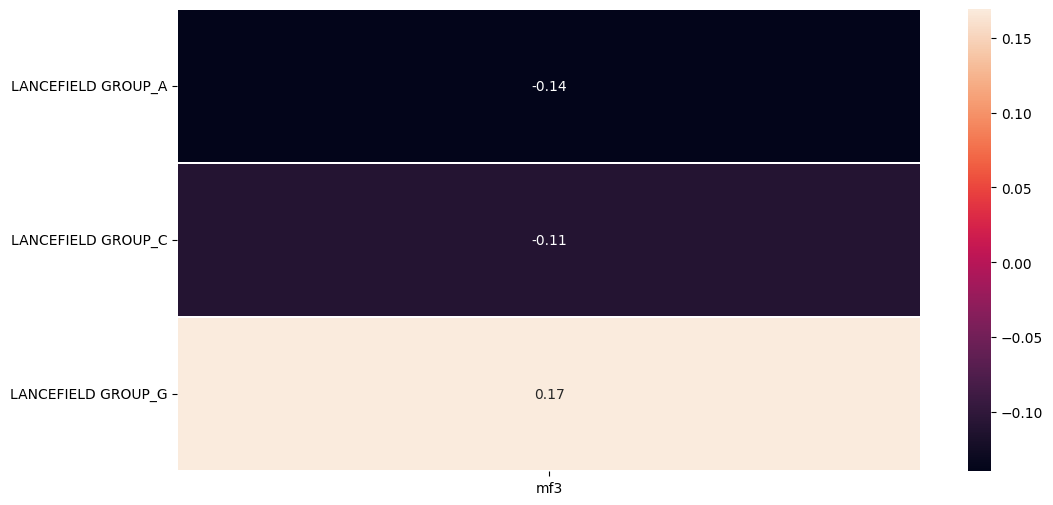

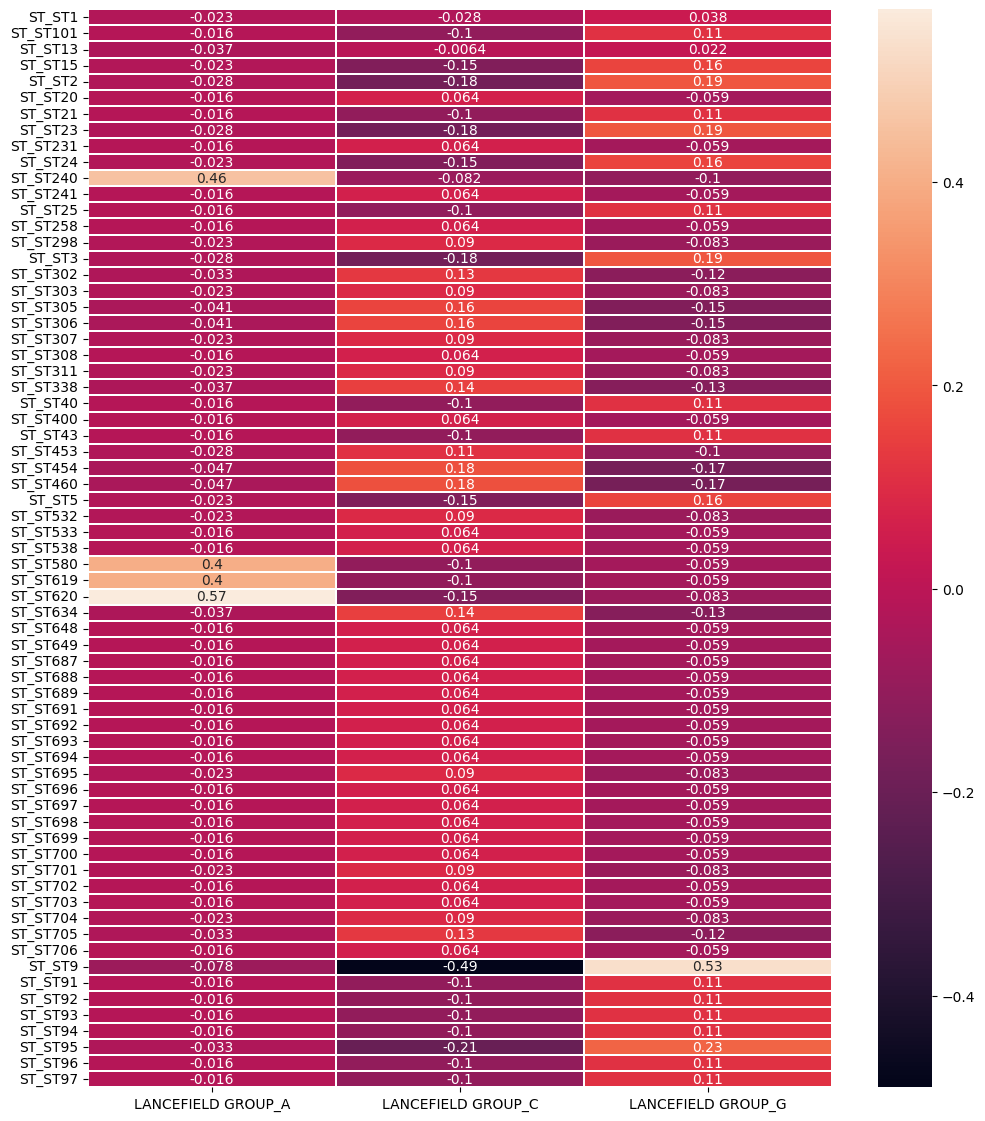

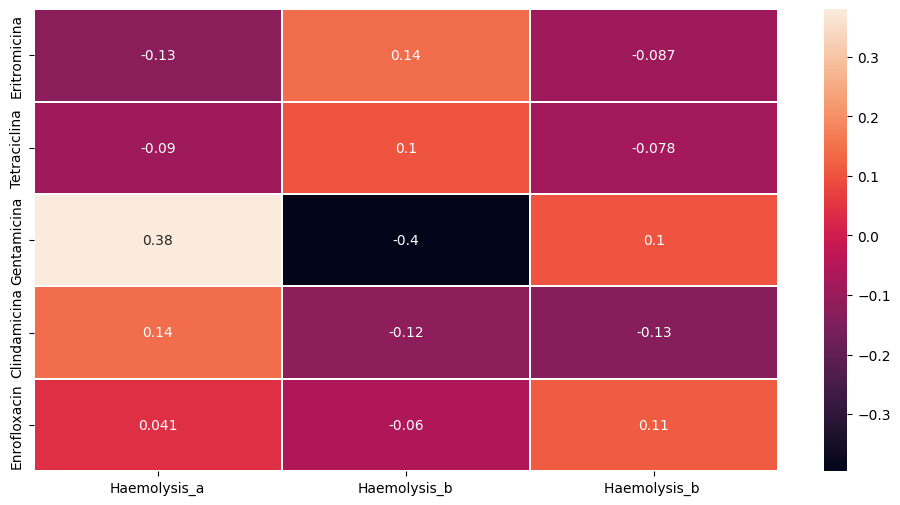

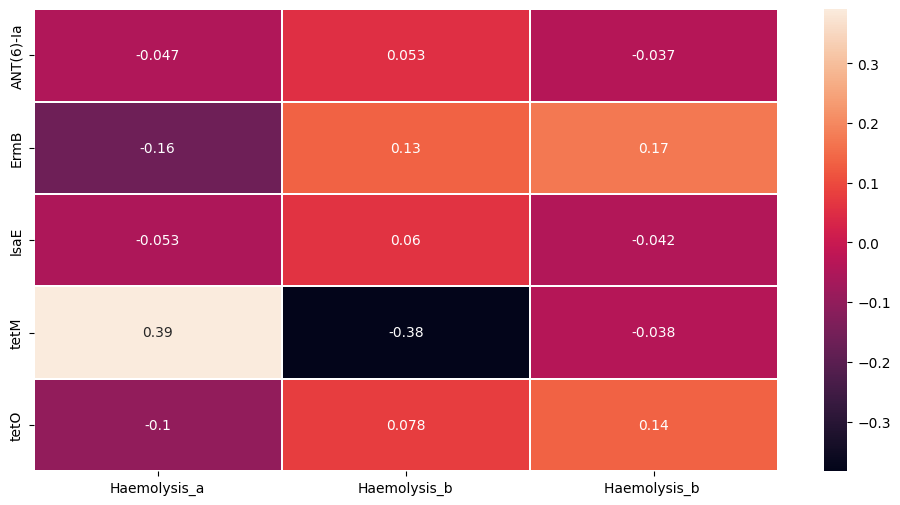

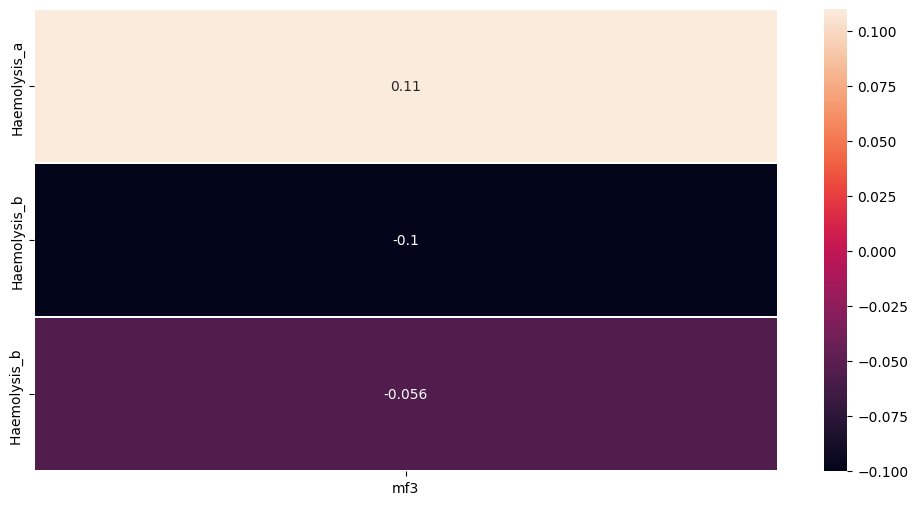

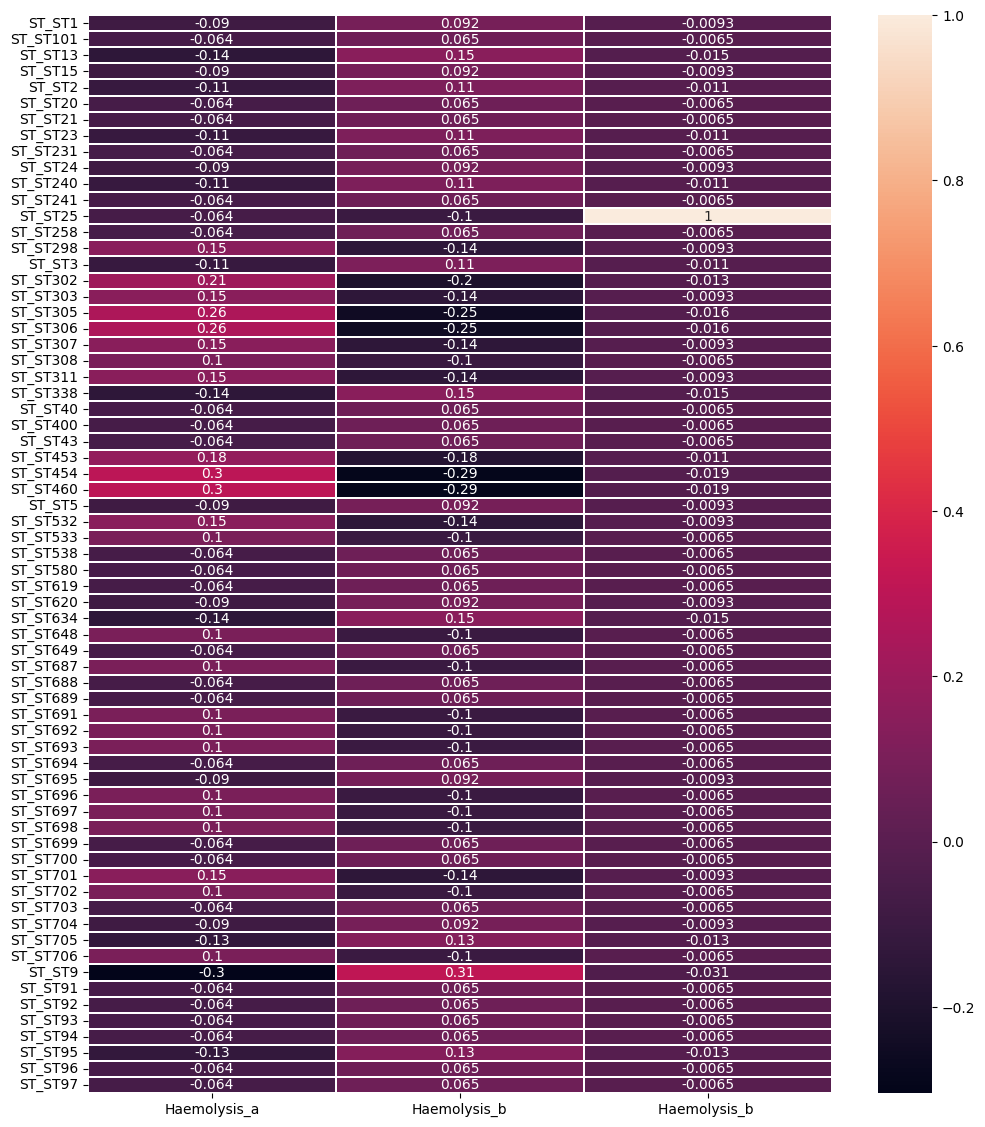

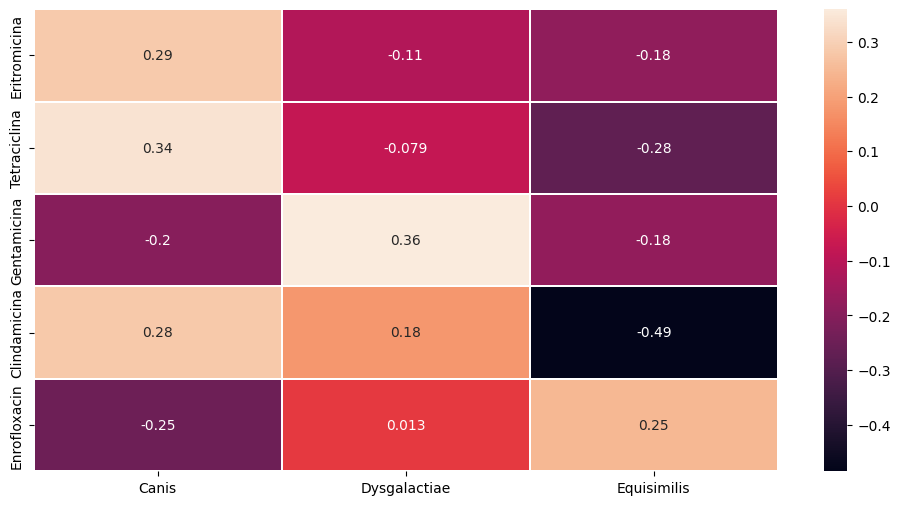

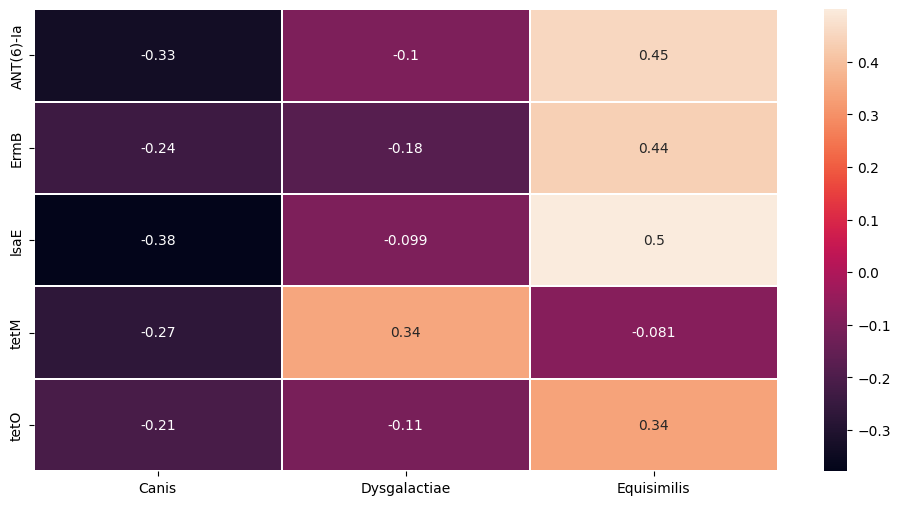

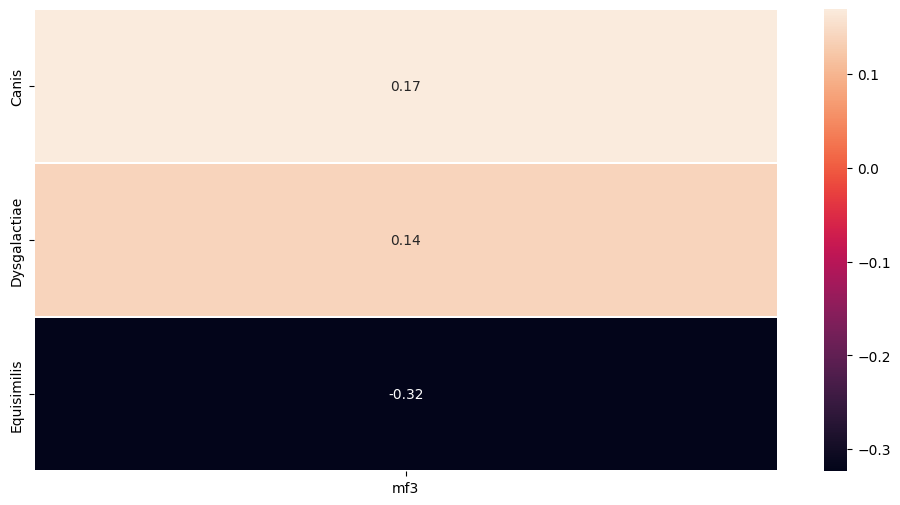

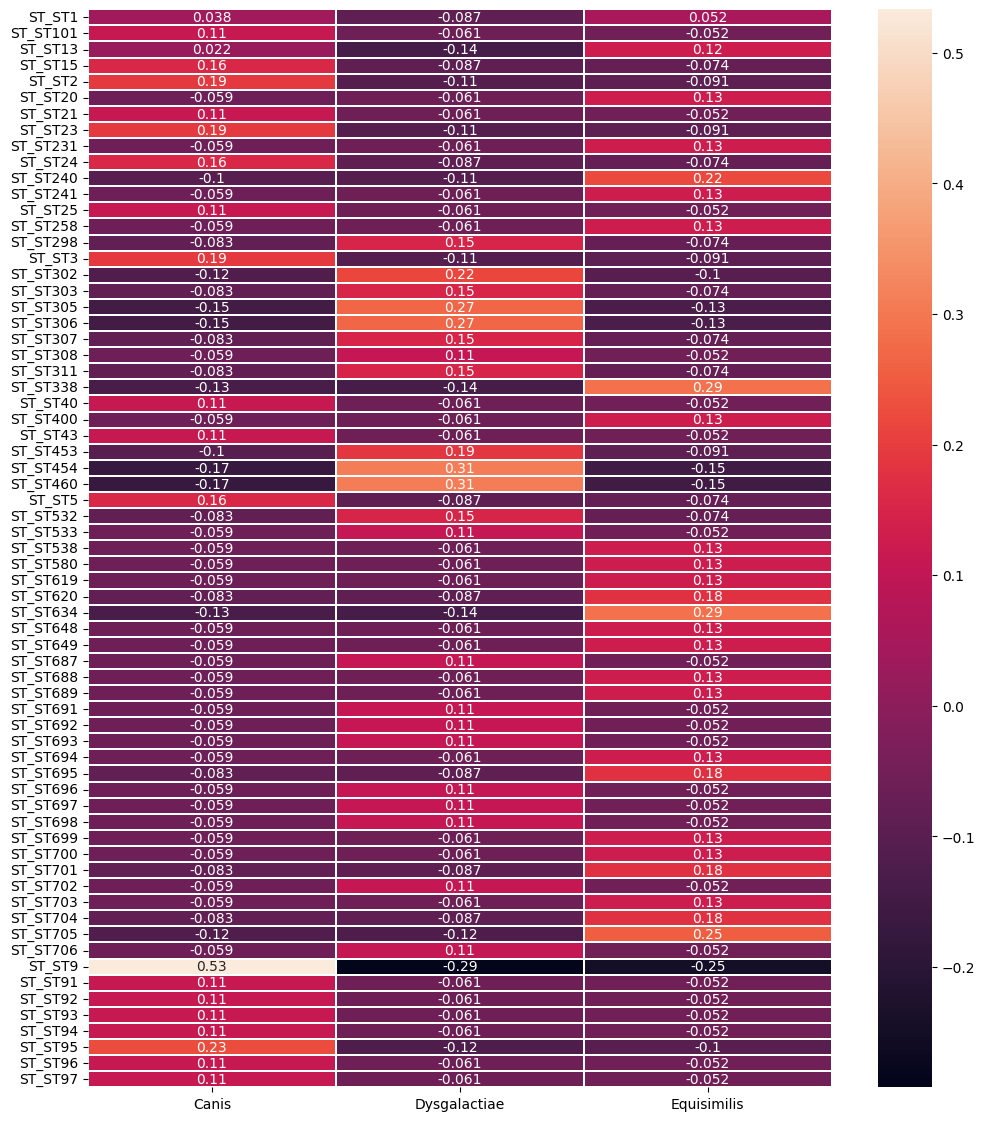

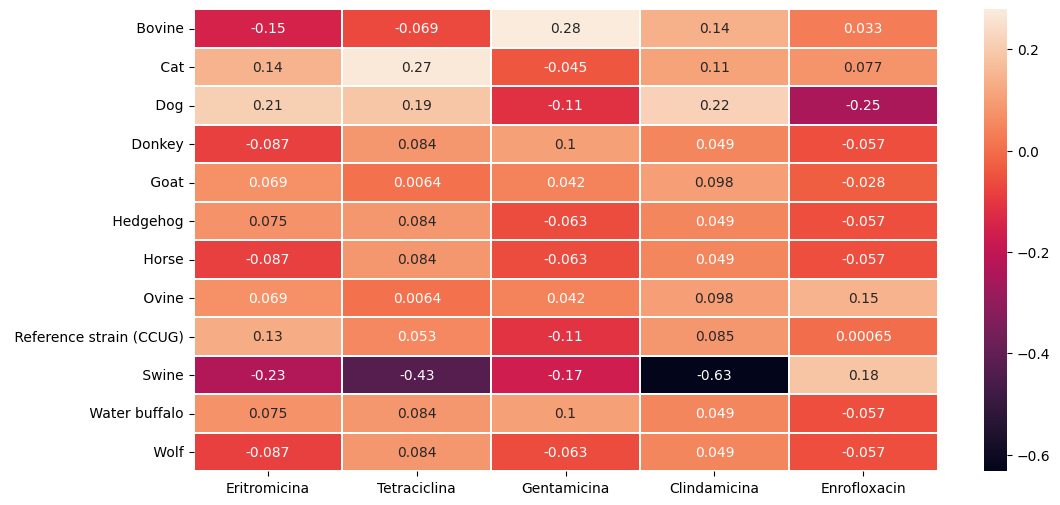

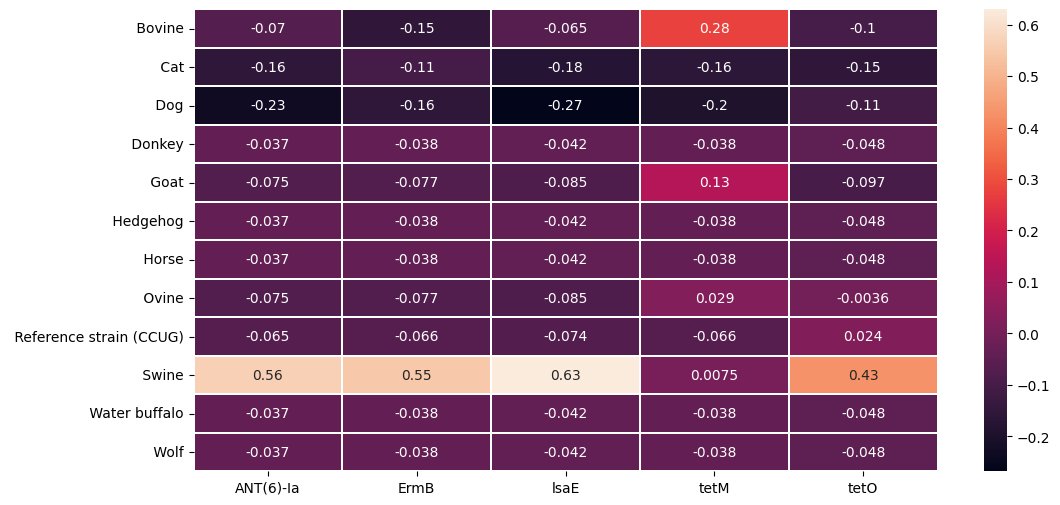

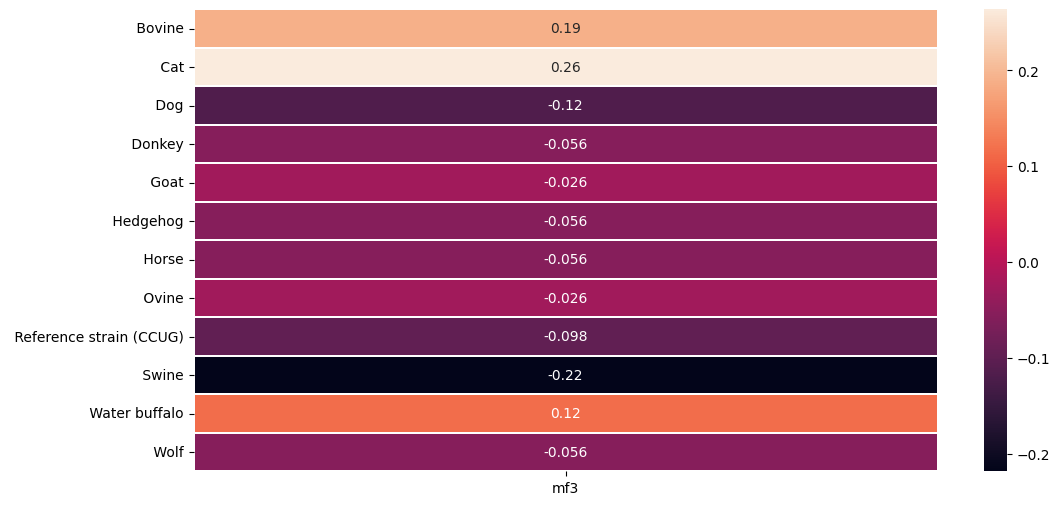

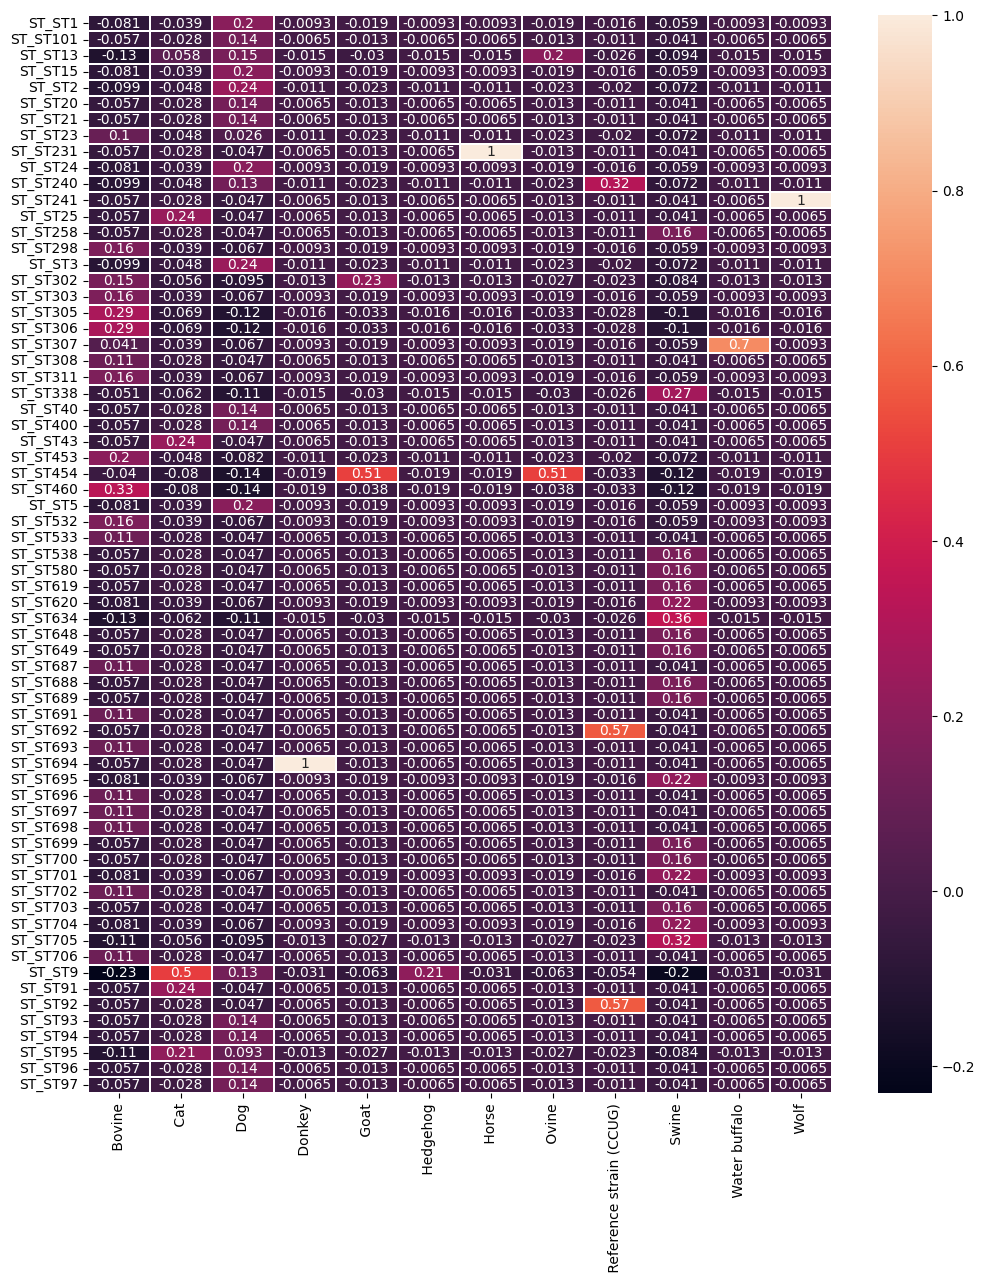

In [52]:
for str_feat, feat_agg in feats_agg.items():
    feat_agg = pd.DataFrame.from_dict(pd.get_dummies(feat_agg))
    if str_feat == 'subspecies':
        feat_agg = feat_agg.rename(columns = {'Putative Subspecies_Streptococcus canis': "Canis",
        'Putative Subspecies_Streptococcus dysgalactiae subsp. equisimilis' : "Equisimilis",
        'Putative Subspecies_Streptococcus dysgalactiae subsp. dysgalactiae' : "Dysgalactiae"})
    if str_feat == 'animal':
        feat_agg.columns = feat_agg.columns.str.replace('Animal species of origin_',' ')
    for str_target, target in targets.items():
        if str_target == 'st':
            target = pd.DataFrame.from_dict(pd.get_dummies(target))
            #print(targ_feat.corr()[feat_agg.columns])
            plt.figure(figsize=(12, 14))
        else:
            plt.figure(figsize=(12, 6))
        targ_feat = pd.concat([target, feat_agg], axis=1)
        print()
        if target.shape[1] > feat_agg.shape[1]:
            corr_target = targ_feat.corr().filter(items = feat_agg.columns.tolist(), axis=1).filter(items = target.columns.tolist(), axis=0)
            sns.heatmap(corr_target, annot=True, linewidths=0.2)
        else:
            corr_feat = targ_feat.corr().filter(items = feat_agg.columns.tolist(), axis=0).filter(items = target.columns.tolist(), axis=1)
            sns.heatmap(corr_feat, annot=True, linewidths=0.2)
        #plt.savefig('Risultati/Correlation/'+str_feat+'_'+str_target+'.png')

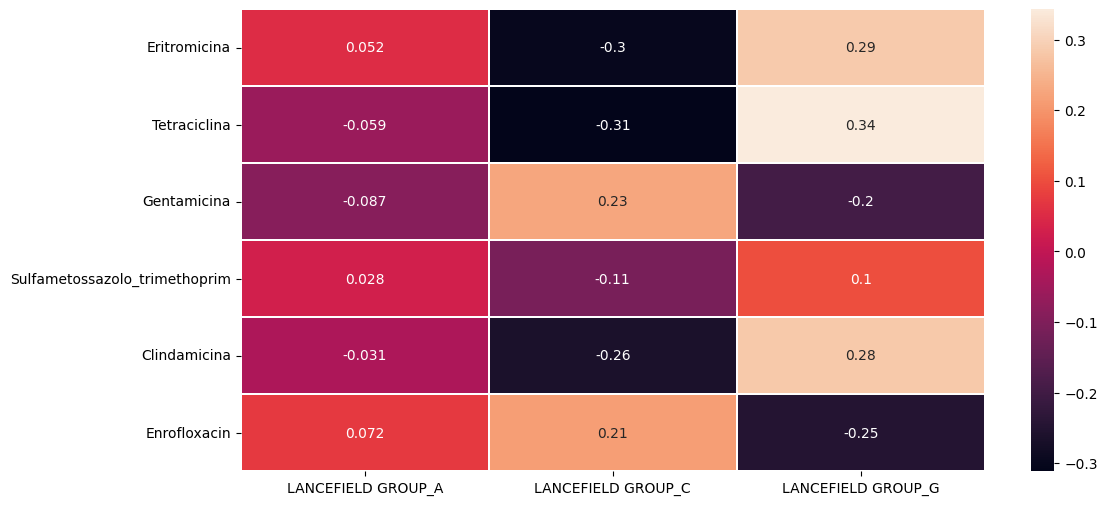

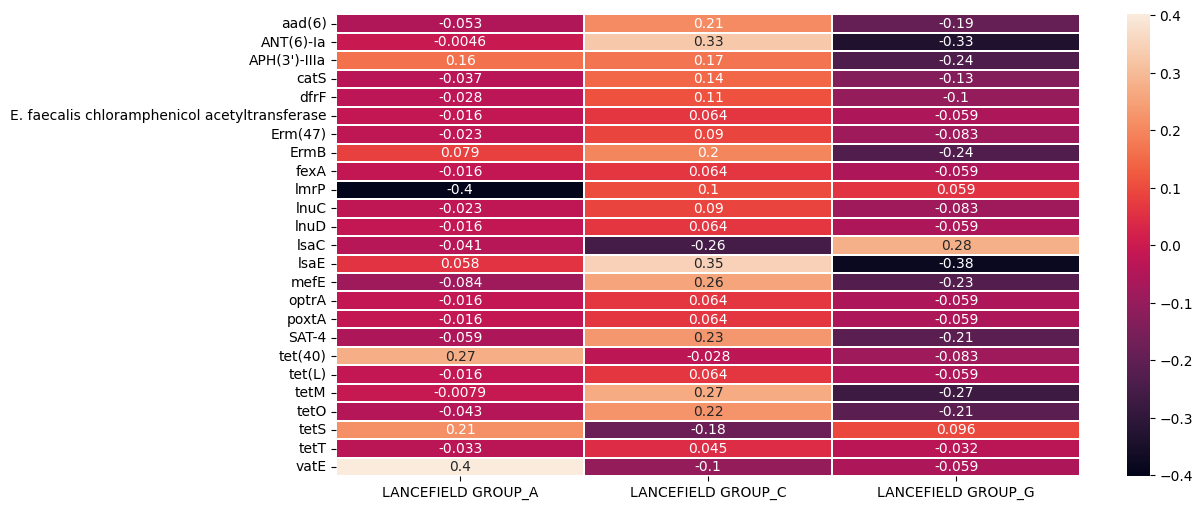

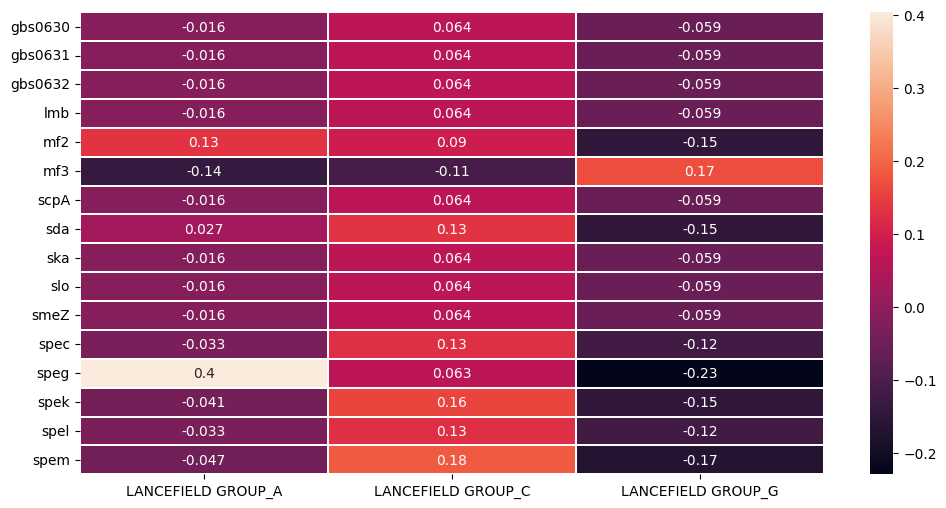

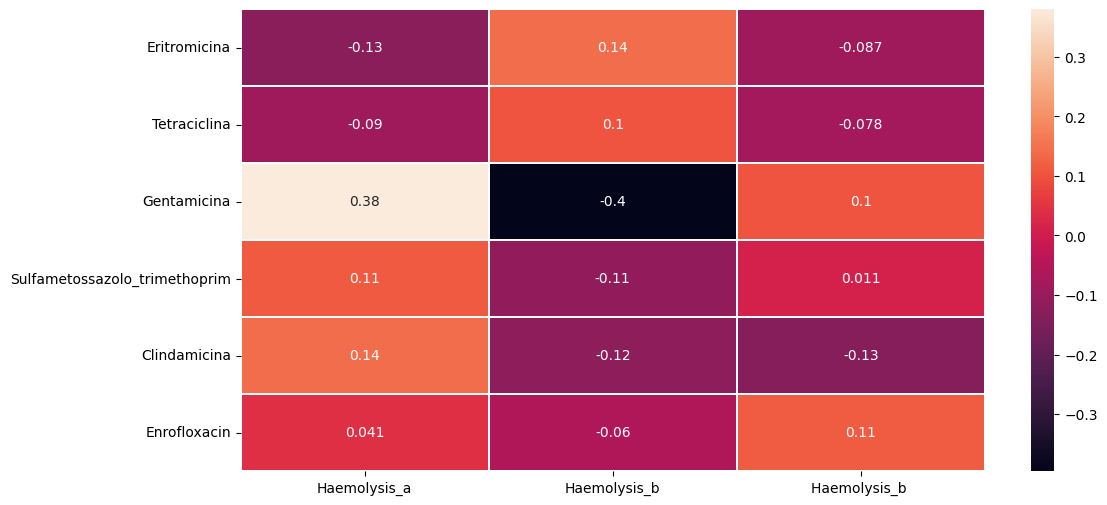

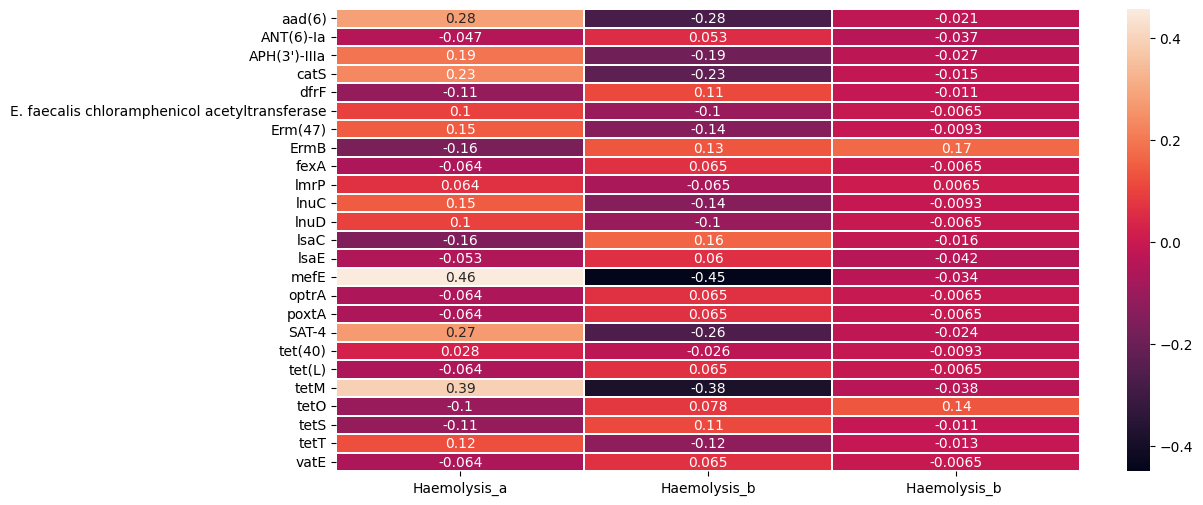

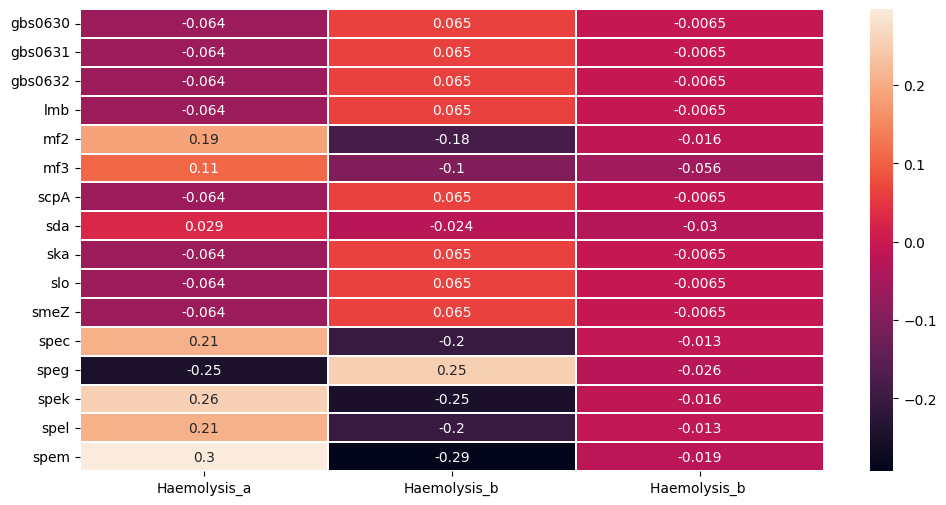

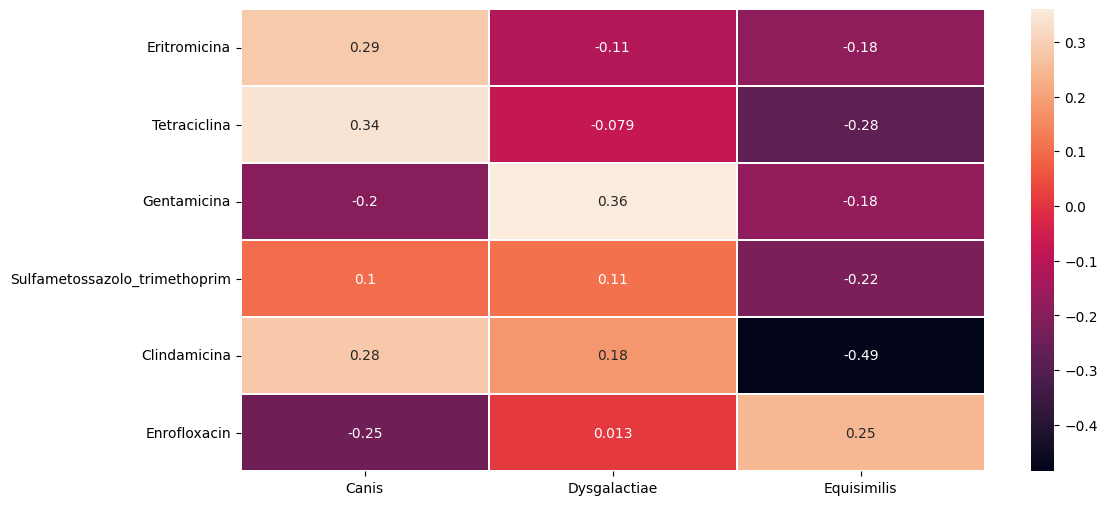

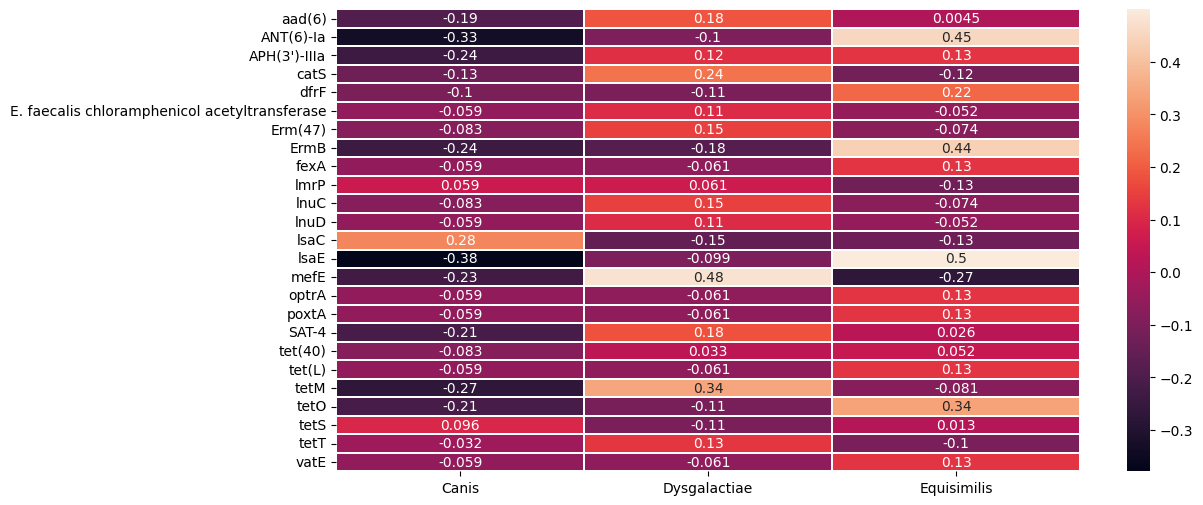

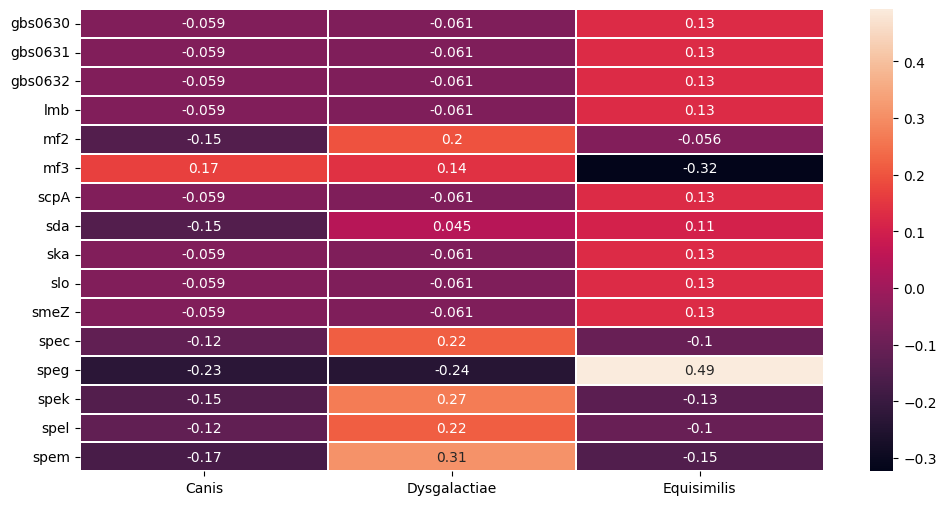

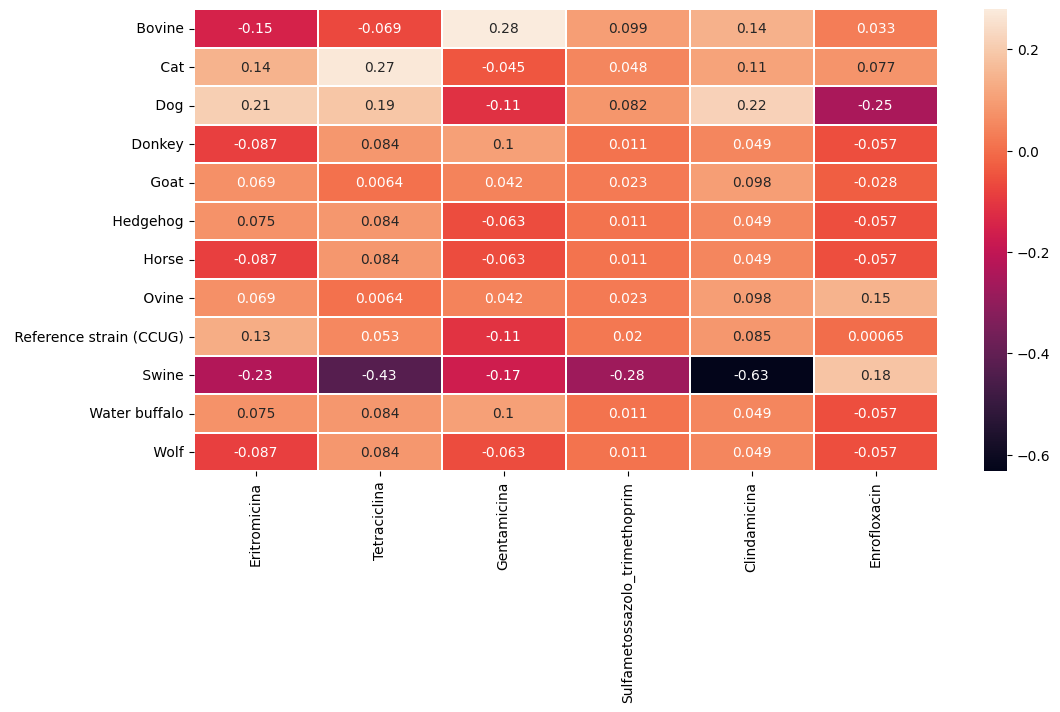

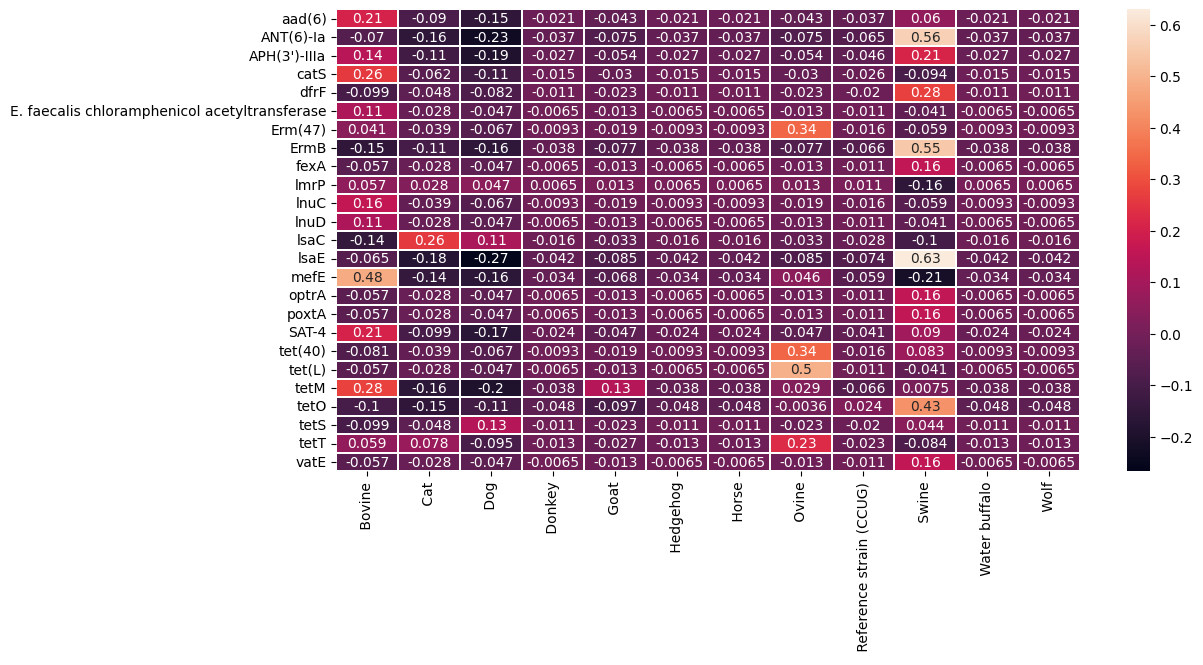

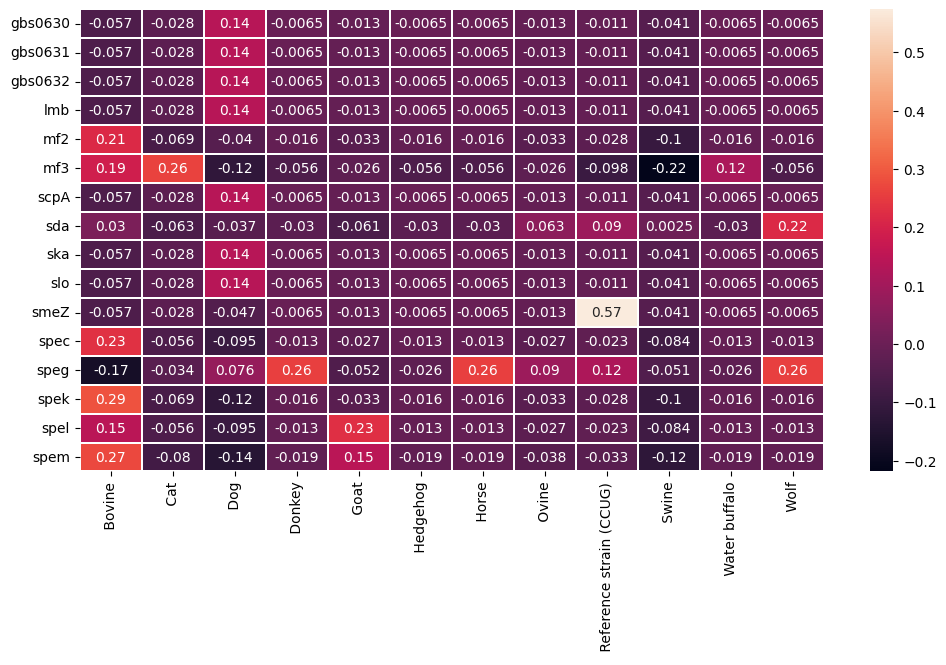

In [53]:

animal  = df[['Animal species of origin']]
lancefield = df[['LANCEFIELD GROUP']]
haemolysis = df[['Haemolysis']]
subspecies = df[['Putative Subspecies']]
st = df[[df.columns[4]]]
antibiotici = df[df.columns[start+n:start+n+n_antibiotici]]
geni_antibiotici = df[df.columns[start+n+n_antibiotici:start+n+n_antibiotici+n_geni]]
virulenza = df[df.columns[start+n+n_antibiotici+n_geni:start+n+n_antibiotici+n_geni+n_virulenza]]

targets = {'antibiotici' : antibiotici,
            'geni_antibiotici' : geni_antibiotici,
            'virulenza' : virulenza}

feats_agg = {'lancefield' : lancefield,
            'haemolysis' : haemolysis,
            'subspecies' : subspecies,
            'animal' : animal}

for str_target,target in targets.items():
    columns = target.columns
    for column in columns:
        if str_target == 'antibiotici':
            target[column] = df[column].map(map_target_antibiotici)
        rapporto = (target[column] == 0).sum() / target.shape[0]
        #print(column+" : "+str(rapporto))
        if rapporto == 0 or rapporto == 1:
            target.drop([column], axis=1, inplace=True)
            
for str_feat, feat_agg in feats_agg.items():
    feat_agg = pd.DataFrame.from_dict(pd.get_dummies(feat_agg))
    if str_feat == 'subspecies':
        feat_agg = feat_agg.rename(columns = {'Putative Subspecies_Streptococcus canis': "Canis",
        'Putative Subspecies_Streptococcus dysgalactiae subsp. equisimilis' : "Equisimilis",
        'Putative Subspecies_Streptococcus dysgalactiae subsp. dysgalactiae' : "Dysgalactiae"})
    if str_feat == 'animal':
        feat_agg.columns = feat_agg.columns.str.replace('Animal species of origin_',' ')
    for str_target, target in targets.items():
        if str_target == 'st':
            target = pd.DataFrame.from_dict(pd.get_dummies(target))
            #print(targ_feat.corr()[feat_agg.columns])
            plt.figure(figsize=(12, 14))
        else:
            plt.figure(figsize=(12, 6))
        targ_feat = pd.concat([target, feat_agg], axis=1)
        #print()
        if target.shape[1] > feat_agg.shape[1]:
            corr_target = targ_feat.corr().filter(items = feat_agg.columns.tolist(), axis=1).filter(items = target.columns.tolist(), axis=0)
            sns.heatmap(corr_target, annot=True, linewidths=0.2)
        else:
            corr_feat = targ_feat.corr().filter(items = feat_agg.columns.tolist(), axis=0).filter(items = target.columns.tolist(), axis=1)
            sns.heatmap(corr_feat, annot=True, linewidths=0.2)
        #plt.savefig('../Risultati/Correlation/'+str_feat+'_'+str_target+'.png')

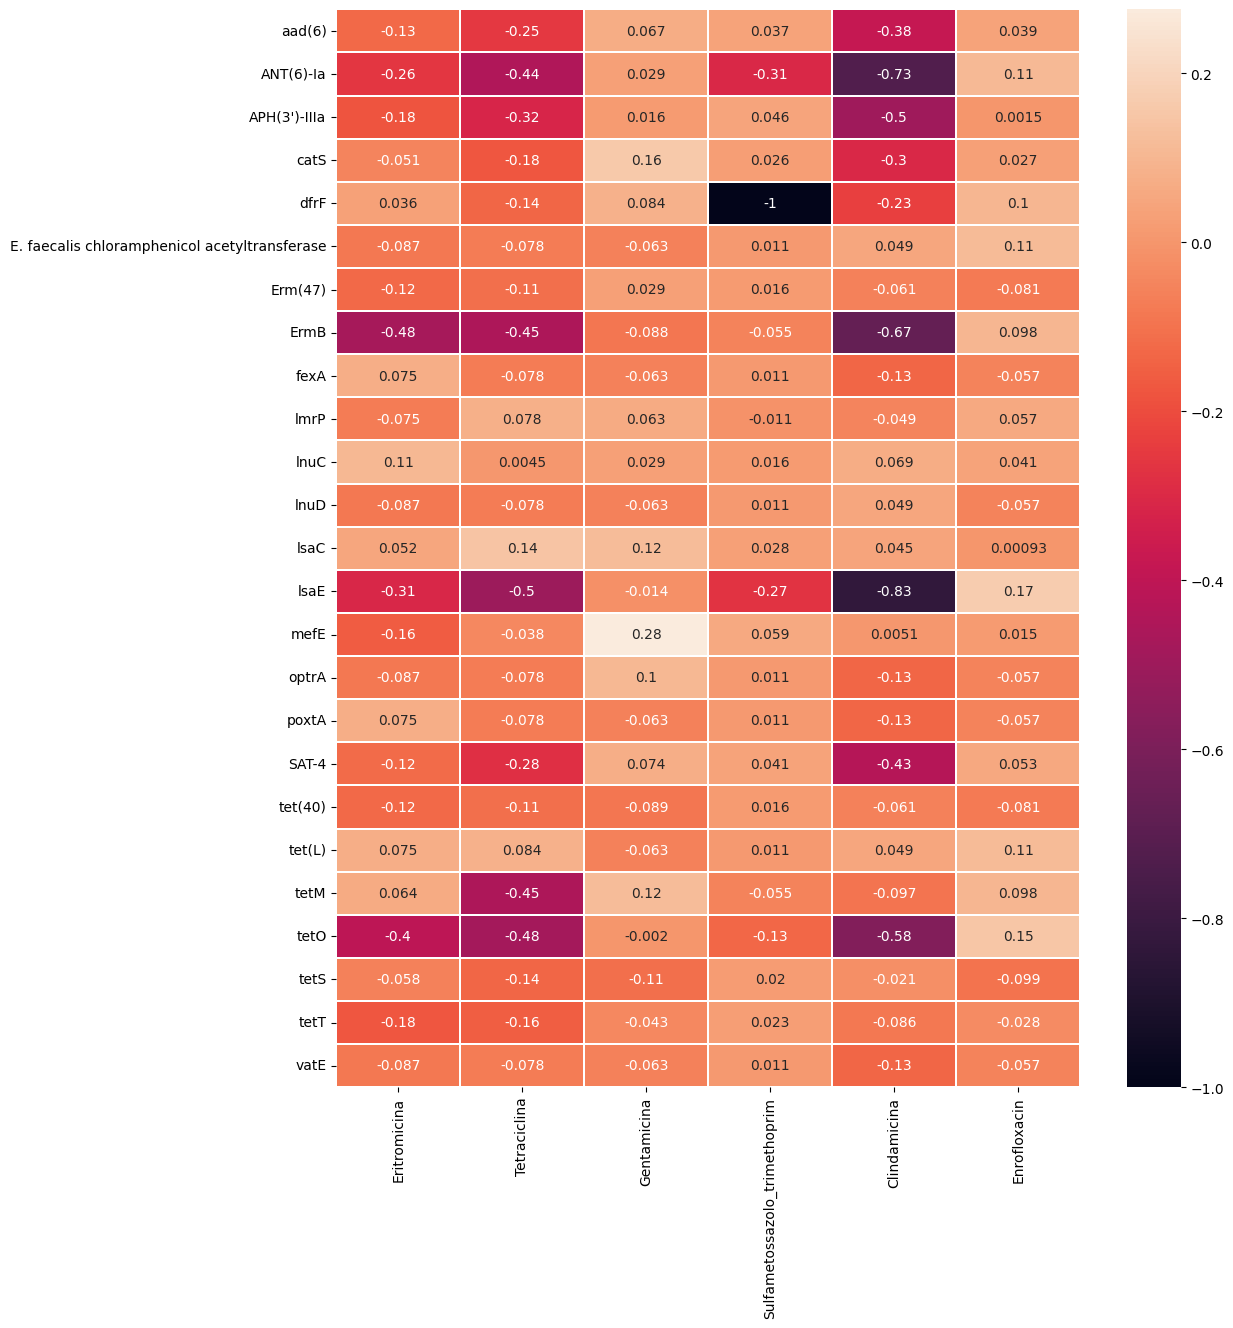

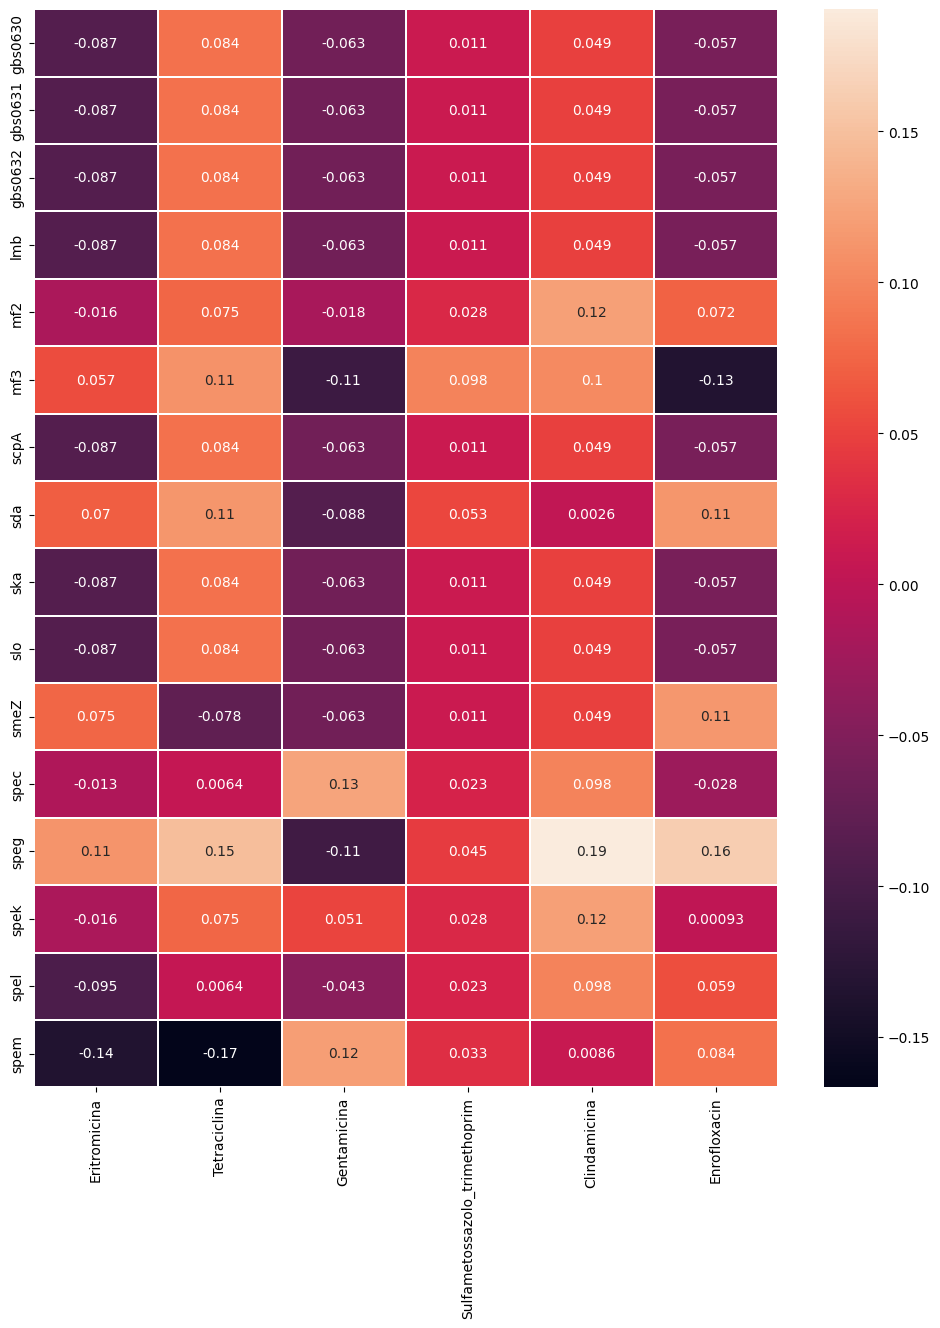

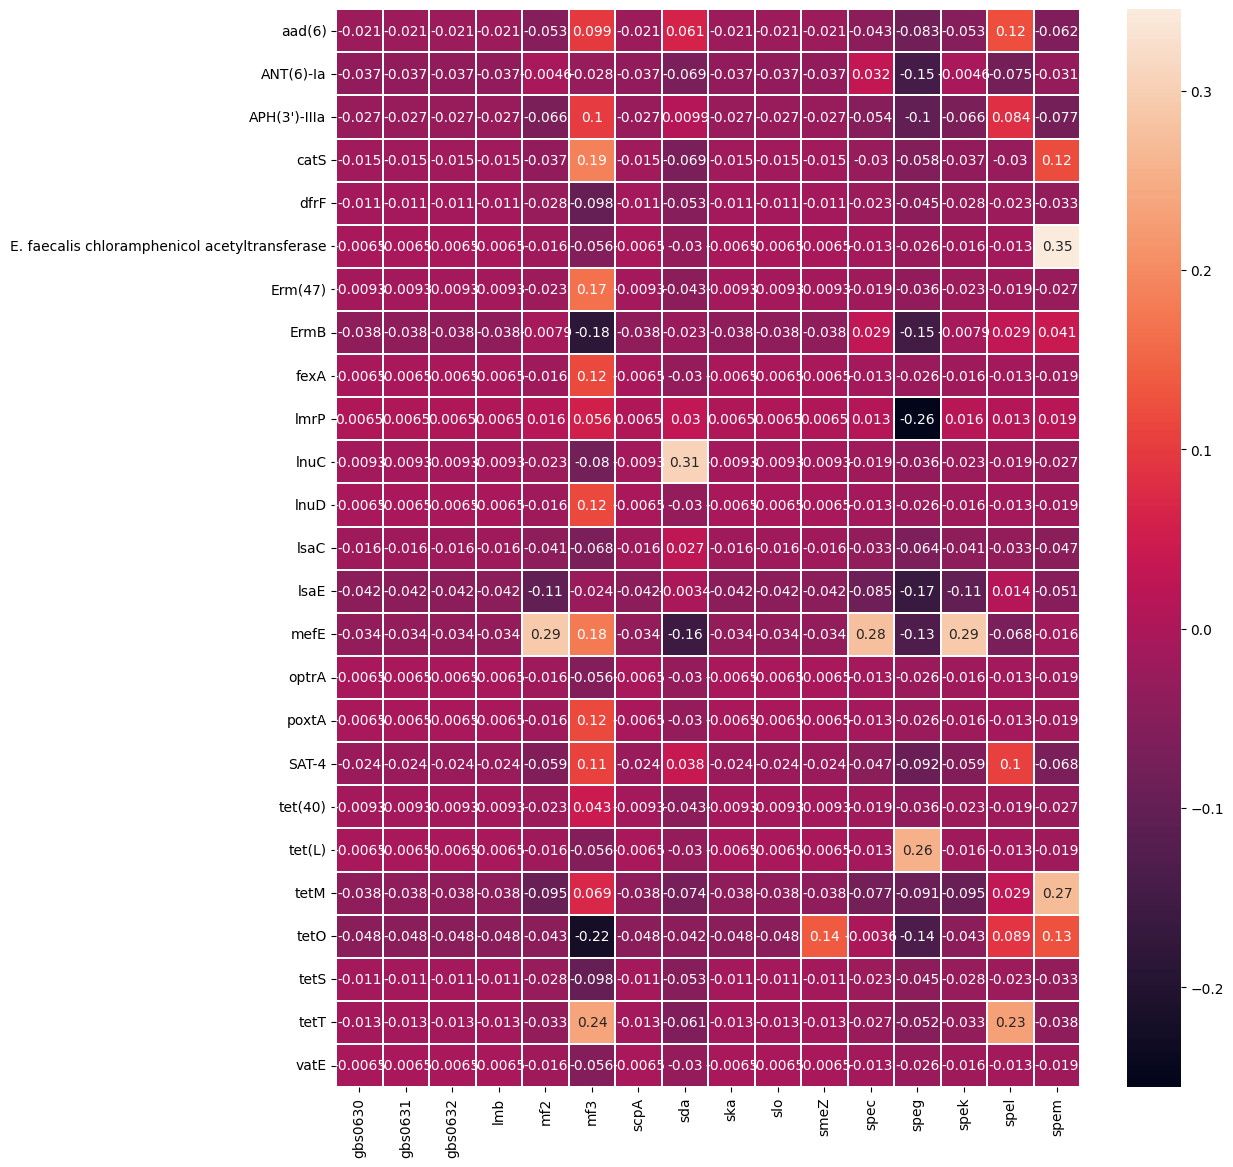

In [54]:
targets2 = targets.copy()
for str_target, target1 in targets.items():
    targets2.pop(str_target)
    for str_target2, target2 in targets2.items():
        plt.figure(figsize=(12, 14))
        targ_feat = pd.concat([target1, target2], axis=1)
        if target1.shape[1] > target2.shape[1]:
            corr_target = targ_feat.corr().filter(items = target2.columns.tolist(), axis=1).filter(items = target1.columns.tolist(), axis=0)
            sns.heatmap(corr_target, annot=True, linewidths=0.2)
        else:
            corr_feat = targ_feat.corr().filter(items = target2.columns.tolist(), axis=0).filter(items = target1.columns.tolist(), axis=1)
            sns.heatmap(corr_feat, annot=True, linewidths=0.2)
        #plt.savefig('../Risultati/Correlation/'+str_target+'_'+str_target2+'.png')